# 1. Imports

In [1]:
import json
import math
import scipy
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics 
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from numpy.random import randn
from random import *
from statistics import mode
from scipy import stats
%matplotlib inline

In [2]:
scipy.__version__

'1.6.2'

# 2. Preparations
## 2.1 Load Data

In [3]:
classrooms = json.load(open('data/raw_data/classrooms.json', 'r'))
pupils = json.load(open('data/raw_data/pupils.json', 'r'))

df = pd.read_pickle('data/processed/df.pkl')
#chat_df = pd.read_pickle("data/processed/chat.pkl")
surveysliders = pd.read_pickle('data/processed/surveySlider.pkl')
inputfields = pd.read_pickle('data/processed/inputFields.pkl')
multipleChoice = pd.read_pickle('data/processed/multipleChoice.pkl')
freetext = pd.read_pickle('data/processed/freetext.pkl')
task_df = pd.read_pickle('data/processed/task_df.pkl')
pupil_performance_df = pd.read_pickle('data/processed/pupil_performance.pkl')
# Laden der Datei, in der händisch alle Freitext-Antworten bewertet wurden
pupil_performance_df_rated = pd.read_csv('data/processed/pupil_performance_3.csv', delimiter=';')
pupil_performance_df_rated = pupil_performance_df_rated.set_index('pupilId')

# set the duration columns to numeric
df['duration'] = pd.to_numeric(df['duration']) #TODO: brauche ich den noch?
surveysliders['duration'] = pd.to_numeric(surveysliders['duration'])
inputfields['duration'] = pd.to_numeric(inputfields['duration'])
multipleChoice['duration'] = pd.to_numeric(multipleChoice['duration'])
freetext['duration'] = pd.to_numeric(freetext['duration'])

pupil_performance_df_rated.head()

,nr_tasks_per_pupil,total_duration in minutes,average duration per task in minutes,AI-1-v2-1-1,AI-4-v2-1-4,EvalML-1-1,ML-2-1-1,EvalML-1-5,AI-4-v2-1-5,EvalML-1-2,...,AIClosing-1-8_eval,AIClosing-1-8_null_answer,AIClosing-1-8_unknown,AIClosing-1-8_correct_points,AIClosing-1-8_incorrect_points,AIClosing-1-8_irrelevant_points,AIClosing-1-8_rating_content,AIClosing-1-8_rating_format,AIClosing-1-8_rating_creativity,classId
pupilId,,,,,,,,,,,,,,,,,,,,,
Ay6mfswm3SFcQdNJg,66,120.116667,1.819949,62.0,91.0,81.0,71.0,75.0,90.0,90.0,...,pending,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
Z9DkQMmtiPiHtteME,4,25.950000,6.487500,43.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
sqBXKssFvS8pFYAMv,66,66.650000,1.009848,89.0,99.0,96.0,79.0,93.0,100.0,98.0,...,correct,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,qFEyvypMn4sAwLwtc
Kd6FuRsrq6QvPrkKp,6,37.383333,6.230556,78.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
jRT6yzZ2ip5ab5ZFM,66,66.566667,1.008586,90.0,88.0,76.0,71.0,69.0,72.0,100.0,...,correct,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,qFEyvypMn4sAwLwtc


## 2.2 Prepare Helper functions

In [4]:
def surveySliderStatistics(column):
    '''Takes the name of a column, and prints a few basic statistics'''
    print(column.name)
    q3, q1 = np.percentile(column.dropna().values, [75 ,25])
    print("Q1: " + str(q1) + " and Q3: " + str(q3))
    print("median: " + str(column.dropna().median()))
    print("mean: " + str(column.dropna().mean()))
    print("std: " +str(round(column.dropna().std(), 2)))
    print("min: " + str(np.min(column.dropna())) + " und max: " + str(np.max(column.dropna())))
    print("")
    
def calculateDifferences(df):
    """Takes a dataframe and returns the differences between the first two columns as a list"""
    differences= []
    for pupilId in df.dropna().index:
        differences.append(df.loc[pupilId, df.columns[0]]-df.loc[pupilId, df.columns[1]])
    return differences

def print_boolean_percentages(series):
    """Takes a series and prints the percentage of correct, incorrect and irrelevant answers"""
    nr_cases = series.value_counts()[True]+series.value_counts()[False]
    percentage_per_case = 100/nr_cases
    true_percentage = series.value_counts()[True]*percentage_per_case
    false_percentage = series.value_counts()[False]*percentage_per_case
    print(series.name + " has: " + str(true_percentage) + "% True null answers: " + str(false_percentage)+ "% right answers")
    
def print_mc(taskIdArray):
    """Takes a list of taskIds and prints the corresponding tasknames, questions, as well as possible and correct answers"""
    for taskID in task_df.index:
        if taskID in taskIdArray:
            print(str(taskID))
            print('\033[1m' + task_df.loc[taskID]["question"] + '\033[0m')
            for i in range(len(task_df.loc[taskID]["answers"])):
                print("*" + task_df.loc[taskID]["answers"][i]["de"] + " - " + str(task_df.loc[taskID]["sampleSolution"][i]))
            print(task_df.loc[taskID]["sampleSolution"])
            print()

def mc_analysis (taskIds):
    """Takes a number of taskIds and prints how many errors each student made, as well as the average number of errors for the tasks"""
    number_errors = []
    for pupilId in pupil_performance_df.index:
        errors = [0 for taskId in taskIds]
        for index, taskId in enumerate(taskIds):
            if(len(pupil_performance_df.loc[pupilId, taskId]) != 0):
                for i in range(len(task_df.loc[taskId, "sampleSolution"])):
                    if pupil_performance_df.loc[pupilId, taskId][i] != task_df.loc[taskId, "sampleSolution"][i]:
                        errors[index] += 1
            elif(len(pupil_performance_df.loc[pupilId, taskId]) == 0):
                errors[index] = np.nan
        number_errors.append(errors)
    
    #errors_sum =  [sum(list) for list in number_errors]
    errors_per_student = [entry for entry in [sum(list) for list in number_errors] if entry==entry]
    #print(errors_sum)
    #print(errors_per_student)
    errors_per_student_series = pd.Series(errors_per_student)
    
    #print("Percentage of students with these numbers of errors: ")
    #print(round(errors_per_student_series.value_counts(normalize=True)*100,2))
    print("\nAverage number of errors: " + str(np.mean(errors_per_student)))
    
    
def number_errors_mc (taskIds):
    """Takes a number of taskIds and returns how many errors each student made"""
    number_errors = []
    for pupilId in pupil_performance_df.index:
        errors = [0 for taskId in taskIds]
        for index, taskId in enumerate(taskIds):
            if(len(pupil_performance_df.loc[pupilId, taskId]) != 0):
                for i in range(len(task_df.loc[taskId, "sampleSolution"])):
                    if pupil_performance_df.loc[pupilId, taskId][i] != task_df.loc[taskId, "sampleSolution"][i]:
                        errors[index] += 1
            elif(len(pupil_performance_df.loc[pupilId, taskId]) == 0):
                errors[index] = np.nan
        number_errors.append(errors)

    errors_sum =  [sum(list) for list in number_errors]
    errors_per_student = [entry for entry in [sum(list) for list in number_errors] if entry==entry]
    return errors_per_student

def analyse_mc(taskIds, numberIndependentQuestions):
    """Pools all function calls applicable for the analysis of multiple choice questions and prints their return values"""
    print_mc(taskIds)
    mc_analysis(taskIds)
    #print(stats.mannwhitneyu(number_errors_mc(taskIds), random_mcs(len(number_errors_mc(taskIds)), numberIndependentQuestions)))
    #print()
    #print("Average p-value over 100 tries: " + str(mannwhitney(taskIds, numberIndependentQuestions)))
    print("Expected number of errors with guessing: ", numberIndependentQuestions/2)

def analyse_partial_mc(taskId, startindex, stopindex):
    """Pools all functions for the analysis of parts of multiple choice answers, given by the start and the stop index
    and prints their return values"""
    sampleSolution = task_df.loc[taskId, "sampleSolution"][startindex-1:stopindex]
    errors = []
    
    for entry in pupil_performance_df[taskId]:
        error_student = 0
        if len(entry)>0:
            for index, solution in enumerate(sampleSolution):
                if entry[startindex-1:stopindex][index] != solution:
                    error_student +=1
    
            errors.append(error_student)

    #print(errors)
    #print("Percentage of students with these numbers of errors: ")
    #errors_per_student_series = pd.Series(errors)
    #print(round(errors_per_student_series.value_counts(normalize=True)*100,2))
    #print()
    average_number_errors = np.mean(errors)
    expected_number_errors = len(sampleSolution)/2
    print("Average number errors in task ", taskId, ": ", average_number_errors)
    print("Expected number errors in task ", taskId, ": ", expected_number_errors)
    return errors

def analyse_combined_mcs(taskId1, taskId2, start1, stop1, start2, stop2):
    """Combines the results of multiple multiple choice answers of different tasks"""
    print_mc(taskId1)
    numberIndependentQuestions = stop1-start1+1+stop2-stop1+1
    errorList1 = analyse_partial_mc(taskId1, start1, stop1)
    print()
    print("-------------------")
    print_mc(taskId2)
    print()
    errorList2 = analyse_partial_mc(taskId2, start2, stop2)
    error_list = [a+b for (a,b) in zip(errorList1,errorList2)]
    #print(error_list)
    print()
    #print("Percentage of students with these numbers of errors: ")
    #errors_per_student_series = pd.Series(error_list)
    #print(round(errors_per_student_series.value_counts(normalize=True)*100,2))
    #print()
    #print("Expected number of errors with guessing: ", numberIndependentQuestions/2)

    
def spearmanr_pval(x,y):
    """returns the p-value of the correlations calculated with spearman rho"""
    return stats.spearmanr(x,y)[1]

def plot_results_per_sus(dfSlice):
    """Plots the results of each student at timepoints T0 and T1"""
    xticklabels = list(dfSlice.dropna().index)
    fig, ax = plt.subplots(figsize = (len(xticklabels)/2,8))
    dfSlice.dropna().plot.line(ax=ax)
    ax.set_xticks(np.arange(len(xticklabels)))
    ax.set_xticklabels(xticklabels)
    plt.xticks(rotation=90)
    plt.show()
    
def plot_improvement_per_sus (dfSlice):
    """Plots the improvements per student between T0 and T1"""
    fig, ax = plt.subplots()

    for pupilId in dfSlice.dropna().index:
        try:
            t0y = pupil_performance_df_rated.loc[pupilId, dfSlice.dropna().columns[0]]
            t1y = pupil_performance_df_rated.loc[pupilId, dfSlice.dropna().columns[1]]
            ax.plot([0, 1], [t0y, t1y], color='gray')
        except:
            pass

    ax.plot([0,1], [np.mean(dfSlice.dropna()[dfSlice.dropna().columns[0]]), np.mean(dfSlice.dropna()[dfSlice.dropna().columns[1]])], color="red")
    plt.show()
    
def plot_improvements(dfSlice):
    """Pools two functions to plot the results and improvements per student at two timepoints"""
    plot_improvement_per_sus (dfSlice)
    plot_results_per_sus(dfSlice)
    
def cohen_d(x,y):
    """Returns cohens d for two populations"""
    # correct only if nx=ny
    #d = (mean(x) - mean(y)) / sqrt((std(x, ddof=1) ** 2 + std(y, ddof=1) ** 2) / 2.0)
    # more general case: implementation correct if the population S.D. is expected to be equal for the two groups:
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    # wenn man nicht die gleiche varianz hat --> cohens d für welch test:
    # [ d = \frac{m_A - m_B}{\sqrt{(Var_1 + Var_2)/2}} ]
    

In [6]:
len(pupil_performance_df_rated["classId"].unique())

11

#### Länge der Freitext abgaben

<AxesSubplot:xlabel='taskId'>

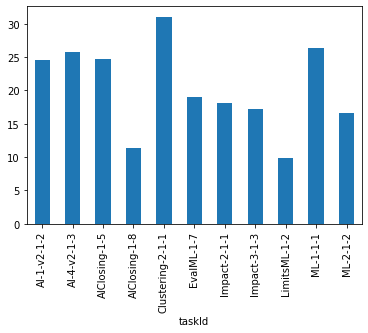

In [14]:
freetext.groupby("taskId")["number words in answer"].agg(np.mean).plot(kind="bar")

#### Länge der Freitext abgaben, die händisch bewertet wurden

----------- AI-1-v2-1-2 --------------


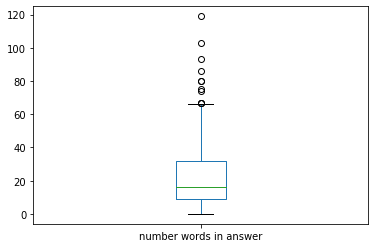

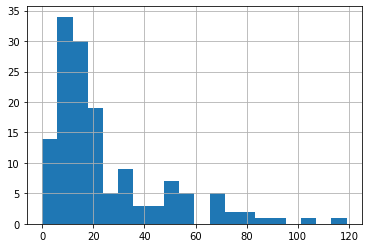

AI-1-v2-1-2
Die meisten Antworten sind zwischen 9.0 und 32.0 Wörtern lang
mean:  24.507042253521128
std:  23.130294286648112
median:  16.0



----------- AI-4-v2-1-3 --------------


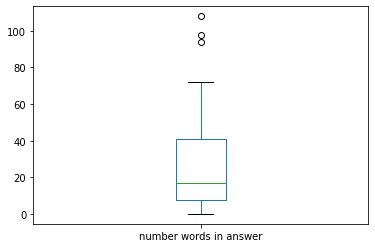

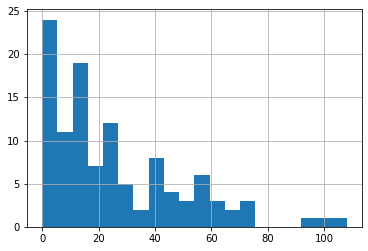

AI-4-v2-1-3
Die meisten Antworten sind zwischen 7.75 und 41.0 Wörtern lang
mean:  25.741071428571427
std:  23.411591121750803
median:  17.0



----------- ML-2-1-2 --------------


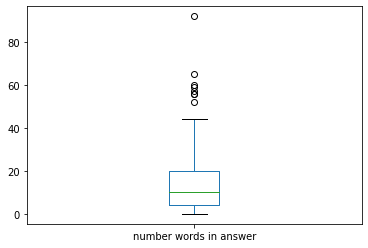

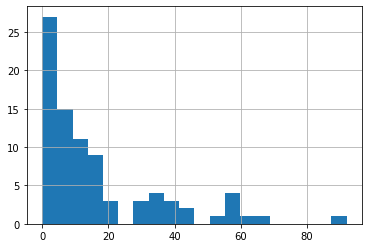

ML-2-1-2
Die meisten Antworten sind zwischen 4.0 und 20.0 Wörtern lang
mean:  16.564705882352943
std:  18.72868015124431
median:  10.0



----------- EvalML-1-7 --------------


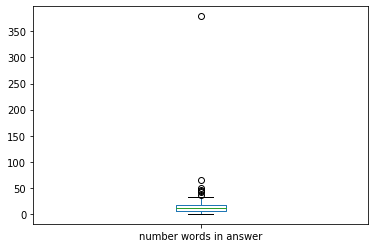

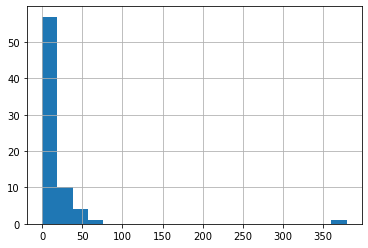

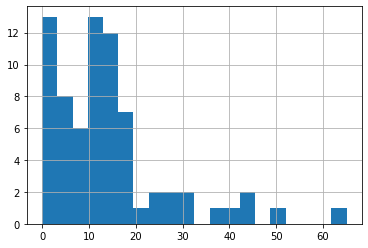

EvalML-1-7
Die meisten Antworten sind zwischen 6.0 und 17.0 Wörtern lang
mean:  18.972602739726028
std:  44.22699002476207
median:  12.0





In [34]:
for taskId in ["AI-1-v2-1-2", "AI-4-v2-1-3", "ML-2-1-2", "EvalML-1-7"]:
    print("-----------",taskId,"--------------")
    freetext[freetext["taskId"] == taskId]["number words in answer"].plot(kind="box")
    plt.show()
    freetext[freetext["taskId"] == taskId]["number words in answer"].hist(bins=20)
    plt.show()
    if (taskId == "EvalML-1-7"):
        freetext[(freetext["taskId"] == taskId) & (freetext["number words in answer"] < 300 )]["number words in answer"].hist(bins=20)
        plt.show()
        
    q3, q1 = np.percentile(freetext[freetext["taskId"] == taskId]["number words in answer"], [75 ,25])
    mean = np.mean(freetext[freetext["taskId"] == taskId]["number words in answer"])
    std = np.std(freetext[freetext["taskId"] == taskId]["number words in answer"])
    median = np.median(freetext[freetext["taskId"] == taskId]["number words in answer"])
    print(taskId)
    print("Die meisten Antworten sind zwischen " + str(q1) + " und " + str(q3) + " Wörtern lang")
    print("mean: ", mean)
    print("std: ", std)
    print("median: ", median)
    print("\n\n")

#### Korrelation Selbsteinschätzung und meine Bewertung

------------------ ('AI-1-v2-1-1', 'AI-1-v2-1-2') ---------------
---pvals---


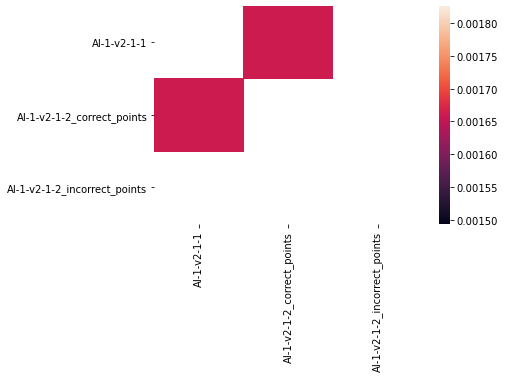

                              AI-1-v2-1-1  AI-1-v2-1-2_correct_points  \
AI-1-v2-1-1                       1.00000                    0.001660   
AI-1-v2-1-2_correct_points        0.00166                    1.000000   
AI-1-v2-1-2_incorrect_points      0.29800                    0.058492   

                              AI-1-v2-1-2_incorrect_points  
AI-1-v2-1-1                                       0.298000  
AI-1-v2-1-2_correct_points                        0.058492  
AI-1-v2-1-2_incorrect_points                      1.000000  
---correlations---


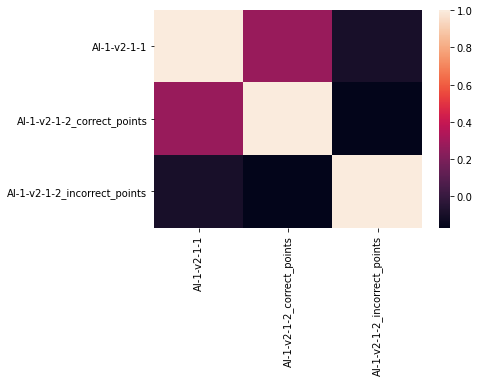

                              AI-1-v2-1-1  AI-1-v2-1-2_correct_points  \
AI-1-v2-1-1                      1.000000                    0.276368   
AI-1-v2-1-2_correct_points       0.276368                    1.000000   
AI-1-v2-1-2_incorrect_points    -0.093823                   -0.169700   

                              AI-1-v2-1-2_incorrect_points  
AI-1-v2-1-1                                      -0.093823  
AI-1-v2-1-2_correct_points                       -0.169700  
AI-1-v2-1-2_incorrect_points                      1.000000  



------------------ ('AI-4-v2-1-4', 'AI-4-v2-1-3') ---------------
---pvals---


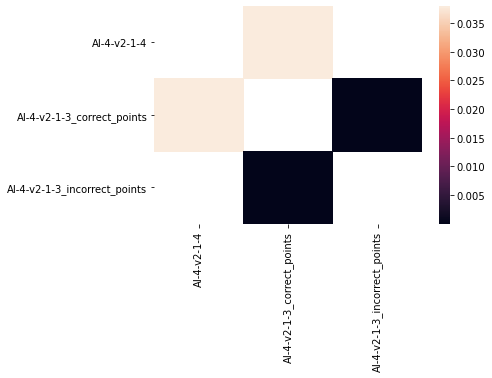

                              AI-4-v2-1-4  AI-4-v2-1-3_correct_points  \
AI-4-v2-1-4                      1.000000                    0.037943   
AI-4-v2-1-3_correct_points       0.037943                    1.000000   
AI-4-v2-1-3_incorrect_points     0.996448                    0.000014   

                              AI-4-v2-1-3_incorrect_points  
AI-4-v2-1-4                                       0.996448  
AI-4-v2-1-3_correct_points                        0.000014  
AI-4-v2-1-3_incorrect_points                      1.000000  
---correlations---


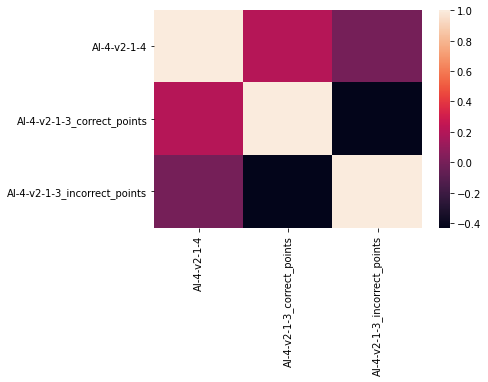

                              AI-4-v2-1-4  AI-4-v2-1-3_correct_points  \
AI-4-v2-1-4                      1.000000                    0.210005   
AI-4-v2-1-3_correct_points       0.210005                    1.000000   
AI-4-v2-1-3_incorrect_points    -0.000463                   -0.429832   

                              AI-4-v2-1-3_incorrect_points  
AI-4-v2-1-4                                      -0.000463  
AI-4-v2-1-3_correct_points                       -0.429832  
AI-4-v2-1-3_incorrect_points                      1.000000  



------------------ ('ML-2-1-1', 'ML-2-1-2') ---------------
---pvals---


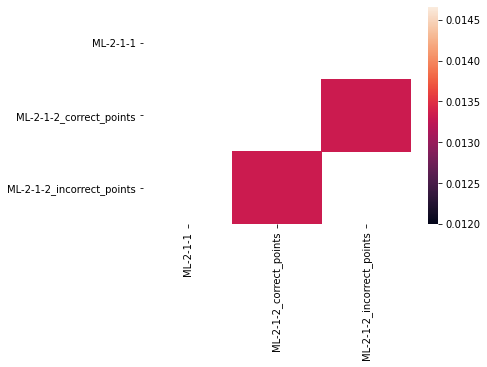

                           ML-2-1-1  ML-2-1-2_correct_points  \
ML-2-1-1                   1.000000                 0.271864   
ML-2-1-2_correct_points    0.271864                 1.000000   
ML-2-1-2_incorrect_points  0.559792                 0.013329   

                           ML-2-1-2_incorrect_points  
ML-2-1-1                                    0.559792  
ML-2-1-2_correct_points                     0.013329  
ML-2-1-2_incorrect_points                   1.000000  
---correlations---


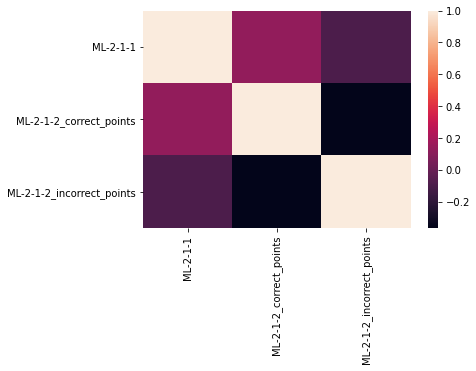

                           ML-2-1-1  ML-2-1-2_correct_points  \
ML-2-1-1                   1.000000                 0.130302   
ML-2-1-2_correct_points    0.130302                 1.000000   
ML-2-1-2_incorrect_points -0.089269                -0.366314   

                           ML-2-1-2_incorrect_points  
ML-2-1-1                                   -0.089269  
ML-2-1-2_correct_points                    -0.366314  
ML-2-1-2_incorrect_points                   1.000000  



------------------ ('EvalML-1-5', 'EvalML-1-7') ---------------
---pvals---


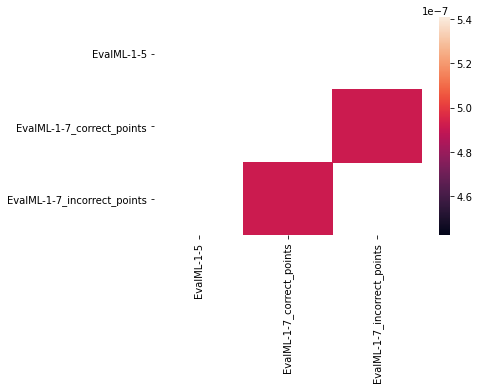

                             EvalML-1-5  EvalML-1-7_correct_points  \
EvalML-1-5                     1.000000               5.014585e-01   
EvalML-1-7_correct_points      0.501459               1.000000e+00   
EvalML-1-7_incorrect_points    0.163164               4.916045e-07   

                             EvalML-1-7_incorrect_points  
EvalML-1-5                                  1.631644e-01  
EvalML-1-7_correct_points                   4.916045e-07  
EvalML-1-7_incorrect_points                 1.000000e+00  
---correlations---


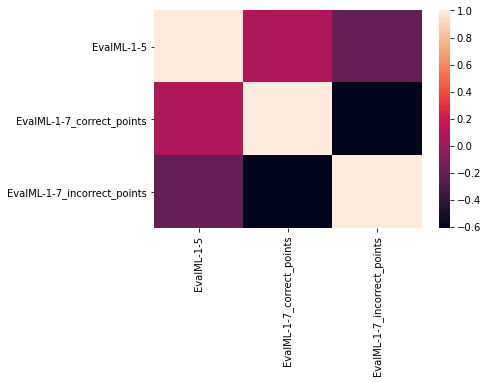

                             EvalML-1-5  EvalML-1-7_correct_points  \
EvalML-1-5                     1.000000                   0.085557   
EvalML-1-7_correct_points      0.085557                   1.000000   
EvalML-1-7_incorrect_points   -0.187217                  -0.609277   

                             EvalML-1-7_incorrect_points  
EvalML-1-5                                     -0.187217  
EvalML-1-7_correct_points                      -0.609277  
EvalML-1-7_incorrect_points                     1.000000  





In [15]:
tasks = [("AI-1-v2-1-1", "AI-1-v2-1-2"), ('AI-4-v2-1-4', "AI-4-v2-1-3"), ("ML-2-1-1", "ML-2-1-2"), ('EvalML-1-5', "EvalML-1-7")]
for tpl in tasks:
    print("------------------", tpl, "---------------")
    print("---pvals---")
    p_values = pupil_performance_df_rated[[tpl[0], tpl[1]+ "_correct_points", tpl[1]+ "_incorrect_points"]].corr(method=spearmanr_pval)
    sns.heatmap(p_values[p_values<0.05])
    plt.show()
    print(p_values)
    
    print("---correlations---")
    sns.heatmap(pupil_performance_df_rated[[tpl[0], tpl[1]+ "_correct_points", tpl[1]+ "_incorrect_points"]].corr(method='spearman'))
    plt.show()
    print(pupil_performance_df_rated[[tpl[0], tpl[1]+ "_correct_points", tpl[1]+ "_incorrect_points"]].corr(method='spearman'))
    print("\n\n")
    
    #part = pupil_performance_df_rated[[tpl[0], tpl[1]+ "_correct_points"]]
    #ax = sns.regplot(x=tpl[0], y=tpl[1]+ "_correct_points", data=part)
    #plt.show()
    
    #part = pupil_performance_df_rated[[tpl[0], tpl[1]+ "_incorrect_points"]]
    #ax = sns.regplot(x=tpl[0], y=tpl[1]+ "_incorrect_points", data=part)
    #plt.show()
    
    #part = pupil_performance_df_rated[[tpl[0], tpl[1]+ "_irrelevant_points"]]
    #ax = sns.regplot(x=tpl[0], y=tpl[1]+ "_irrelevant_points", data=part)
    #plt.show()

Könnte noch einen Hypothesentest für die korrelationen machen, aber nur wenn das wichtig ist und ist es eigentlich nicht!

In [49]:
taskIdsMA = ['Clustering-2-1-1', 'AI-1-v2-1-1', 'AI-1-v2-1-2', 'AI-1-v2-2-1',
             'AI-2-v2-1-1', 'EvalML-1-1', 'EvalML-1-2', 'EvalML-1-3', 'EvalML-1-4',
             'EvalML-1-5', 'EvalML-1-6', 'EvalML-1-7', 'EvalML-1-8', 'EvalML-1-9',
             'LimitsML-1-1', 'LimitsML-1-2', 'Classification-1-1-1', 'Clustering-1-1-1',
             'Clustering-1-1-2', 'Clustering-1-1-3', 'Clustering-1-1-4', 'AI-3-v2-1-1',
             'AI-3-v2-1-2', 'Classification-2-1-1', 'Classification-2-1-2', 'Classification-2-1-3',
             'Classification-2-1-4', 'Classification-2-1-6', 'Classification-2-1-7',
             'Classification-2-1-8', 'ML-2-1-1', 'ML-2-1-2', 'ML-2-1-3', 'AI-4-v2-1-1',
             'AI-4-v2-1-2', 'AI-4-v2-1-3', 'AI-4-v2-1-4', 'AI-4-v2-1-5', 'ML-3-1-1',
             'ML-3-1-2', 'ML-3-1-3', 'ML-3-1-4', 'ML-1-1-1', 'ML-1-1-2', 'ML-1-1-3', 'ML-1-1-4']
median_task_durations = []

for taskId in taskIdsMA:
    median_task_duration = np.median(df[df["taskId"] == taskId]["duration"].dropna())
    median_task_durations.append(median_task_duration)

np.sum(median_task_durations)/60

31.091666666666665

In [8]:

# werden alle MCs am anfang nur leer abgegeben


1358

In [32]:
numberRushed = 0

for entry in multipleChoice["falseAttempts"].dropna():
    onlyFalse = [False for boolean in entry[0]]
    if (entry[0] == onlyFalse):
        numberRushed += 1

print("So viele MCs werden als komplett false abgegeben im first attempt: ", numberRushed)
print("So viele MCs wurden insgesamt abgegeben: ", len(multipleChoice["falseAttempts"].dropna()))

print("Könnte mir die fälle noch genauer anschauen. Immer wenige SuS, die das machen?")

So viele MCs werden als komplett false abgegeben im first attempt:  39
So viele MCs wurden insgesamt abgegeben:  1358
Könnte mir die fälle noch genauer anschauen. Immer wenige SuS, die das machen?


In [6]:
pupil_performance_df_rated.keys()

Index(['nr_tasks_per_pupil', 'total_duration in minutes',
       'average duration per task in minutes', 'AI-1-v2-1-1', 'AI-4-v2-1-4',
       'EvalML-1-1', 'ML-2-1-1', 'EvalML-1-5', 'AI-4-v2-1-5', 'EvalML-1-2',
       ...
       'AIClosing-1-8_eval', 'AIClosing-1-8_null_answer',
       'AIClosing-1-8_unknown', 'AIClosing-1-8_correct_points',
       'AIClosing-1-8_incorrect_points', 'AIClosing-1-8_irrelevant_points',
       'AIClosing-1-8_rating_content', 'AIClosing-1-8_rating_format',
       'AIClosing-1-8_rating_creativity', 'classId'],
      dtype='object', length=104)

In [21]:
print(pupil_performance_df_rated["classId"].unique())

classCountDict = {classId: 0 for classId in pupil_performance_df_rated["classId"].unique()}
print(classCountDict)
classCountDict["qFEyvypMn4sAwLwtc"]

['qFEyvypMn4sAwLwtc' 'GkQSJvPTRWsLnpyR9' 'hZ9Hi9DLZSm5JMbNm'
 'NCm8NNbAmNsur5S33' '2xefmoTfmYkhhAZYp' 'Rv7Wf522ZgQhs5LdX'
 'Fj6vLBZ78KswTxcPt' 'SwfuMxSGoy4aKziD8' '93uw8K4BBFGYSbYRK'
 '3dLAJPXXug3EMqbc5' 'brSDebuCak3FfQsg6']
{'qFEyvypMn4sAwLwtc': 0, 'GkQSJvPTRWsLnpyR9': 0, 'hZ9Hi9DLZSm5JMbNm': 0, 'NCm8NNbAmNsur5S33': 0, '2xefmoTfmYkhhAZYp': 0, 'Rv7Wf522ZgQhs5LdX': 0, 'Fj6vLBZ78KswTxcPt': 0, 'SwfuMxSGoy4aKziD8': 0, '93uw8K4BBFGYSbYRK': 0, '3dLAJPXXug3EMqbc5': 0, 'brSDebuCak3FfQsg6': 0}


In [39]:
classCountDictAll = {classId: 0 for classId in pupil_performance_df_rated["classId"].unique()}
classCountDict7 = {classId: 0 for classId in pupil_performance_df_rated["classId"].unique()}
classCountDict8 = {classId: 0 for classId in pupil_performance_df_rated["classId"].unique()}

for index, row in pupil_performance_df_rated[["EvalML-1-8", "classId"]].dropna().iterrows():
    if(len(row["EvalML-1-8"])>5):
        classCountDictAll[row["classId"]] += 1
        if(ast.literal_eval(row["EvalML-1-8"])[6] != True):
            classCountDict7[row["classId"]] += 1
        if(ast.literal_eval(row["EvalML-1-8"])[7] != True):
            classCountDict8[row["classId"]] += 1

print(classCountDict8)

{'qFEyvypMn4sAwLwtc': 1, 'GkQSJvPTRWsLnpyR9': 4, 'hZ9Hi9DLZSm5JMbNm': 0, 'NCm8NNbAmNsur5S33': 3, '2xefmoTfmYkhhAZYp': 0, 'Rv7Wf522ZgQhs5LdX': 0, 'Fj6vLBZ78KswTxcPt': 4, 'SwfuMxSGoy4aKziD8': 3, '93uw8K4BBFGYSbYRK': 0, '3dLAJPXXug3EMqbc5': 10, 'brSDebuCak3FfQsg6': 4}


In [38]:
classCountDictAll = {classId: 0 for classId in pupil_performance_df_rated["classId"].unique()}

for index, row in pupil_performance_df_rated[["EvalML-1-8", "classId"]].dropna().iterrows():
    if(len(row["EvalML-1-8"])>5):
        #print(ast.literal_eval(row["EvalML-1-8"])[6])
        #if(ast.literal_eval(row["EvalML-1-8"])[6] != True):
        classCountDictAll[row["classId"]] += 1

print(classCountDictAll)

{'qFEyvypMn4sAwLwtc': 10, 'GkQSJvPTRWsLnpyR9': 5, 'hZ9Hi9DLZSm5JMbNm': 0, 'NCm8NNbAmNsur5S33': 11, '2xefmoTfmYkhhAZYp': 0, 'Rv7Wf522ZgQhs5LdX': 0, 'Fj6vLBZ78KswTxcPt': 11, 'SwfuMxSGoy4aKziD8': 11, '93uw8K4BBFGYSbYRK': 0, '3dLAJPXXug3EMqbc5': 15, 'brSDebuCak3FfQsg6': 9}


In [41]:
pupil_performance_df_rated[pupil_performance_df_rated["classId"]=='3dLAJPXXug3EMqbc5'][["nr_tasks_per_pupil"]]

,nr_tasks_per_pupil
pupilId,
AAgNAMNQscqEwnnQp,48
7vnPeJDmhkYE9zdrM,66
RCvrnYZq9Q262BPgi,66
tsvaTSDWpPbLTpvex,66
oX6Z8YXDvABBdmAfm,35
JqPnAtx5bCoXz9fZE,66
cpkJS3soboSzFuTkk,44
aBaFCcv3MCxmXfCRg,44
T2z2HC9FNA4MgJJjw,66


# 3. Evaluation Lernfortschritt

## 3.1 Was ist KI
### 3.1.1 Was ist KI - Selbsteinschätzung
Selbsteinschätzung der SuS zu drei verschiedenen Zeitpunkten:
* T0: AI-1-v2-1-1
* T1-1 'AI-4-v2-1-4', 'Wie gut hast du jetzt verstanden, was KI ist?'
* T1-2 'EvalML-1-1' Wie gut hast du verstanden, was KI ist?

In [5]:
print(len(pupil_performance_df[["EvalML-1-1"]].dropna()))
print(len(pupil_performance_df[['AI-4-v2-1-4']].dropna()))
print(len(pupil_performance_df[["AI-1-v2-1-1"]].dropna()))

72
111
141


Daten von 141 SuS bei der ersten, 111 für die zweite und 72 SuS, bei der letzten Selbsteinschätzungen.
#### Was ist KI - Selbsteinschätzung - Schüler-Antworten

-------Mit allen Daten------
AI-1-v2-1-1
Q1: 47.0 and Q3: 82.0
median: 65.0
mean: 61.843971631205676
std: 27.49
min: 1.0 und max: 100.0

AI-4-v2-1-4
Q1: 52.0 and Q3: 92.0
median: 68.0
mean: 68.63063063063063
std: 25.23
min: 1.0 und max: 100.0

EvalML-1-1
Q1: 45.75 and Q3: 80.25
median: 65.0
mean: 62.888888888888886
std: 25.18
min: 1.0 und max: 100.0



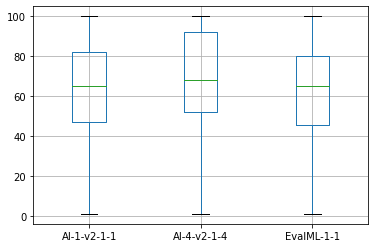

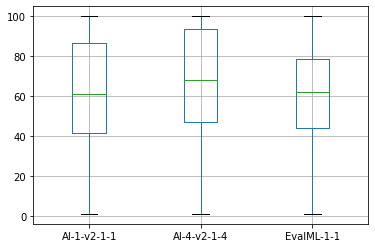


-------Nur mit vollständigen Daten------
AI-1-v2-1-1
Q1: 41.5 and Q3: 86.5
median: 61.0
mean: 61.08474576271186
std: 29.29
min: 1.0 und max: 100.0

AI-4-v2-1-4
Q1: 47.0 and Q3: 93.5
median: 68.0
mean: 66.91525423728814
std: 27.01
min: 1.0 und max: 100.0

EvalML-1-1
Q1: 44.0 and Q3: 78.5
median: 62.0
mean: 61.355932203389834
std: 24.88
min: 1.0 und max: 100.0



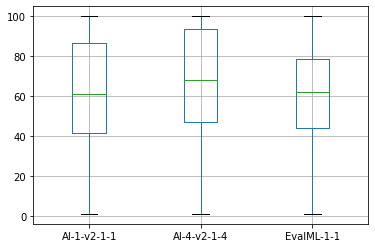


-----Average Improvements & je SuS T0-T0.5-----


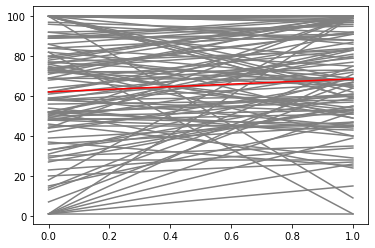

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


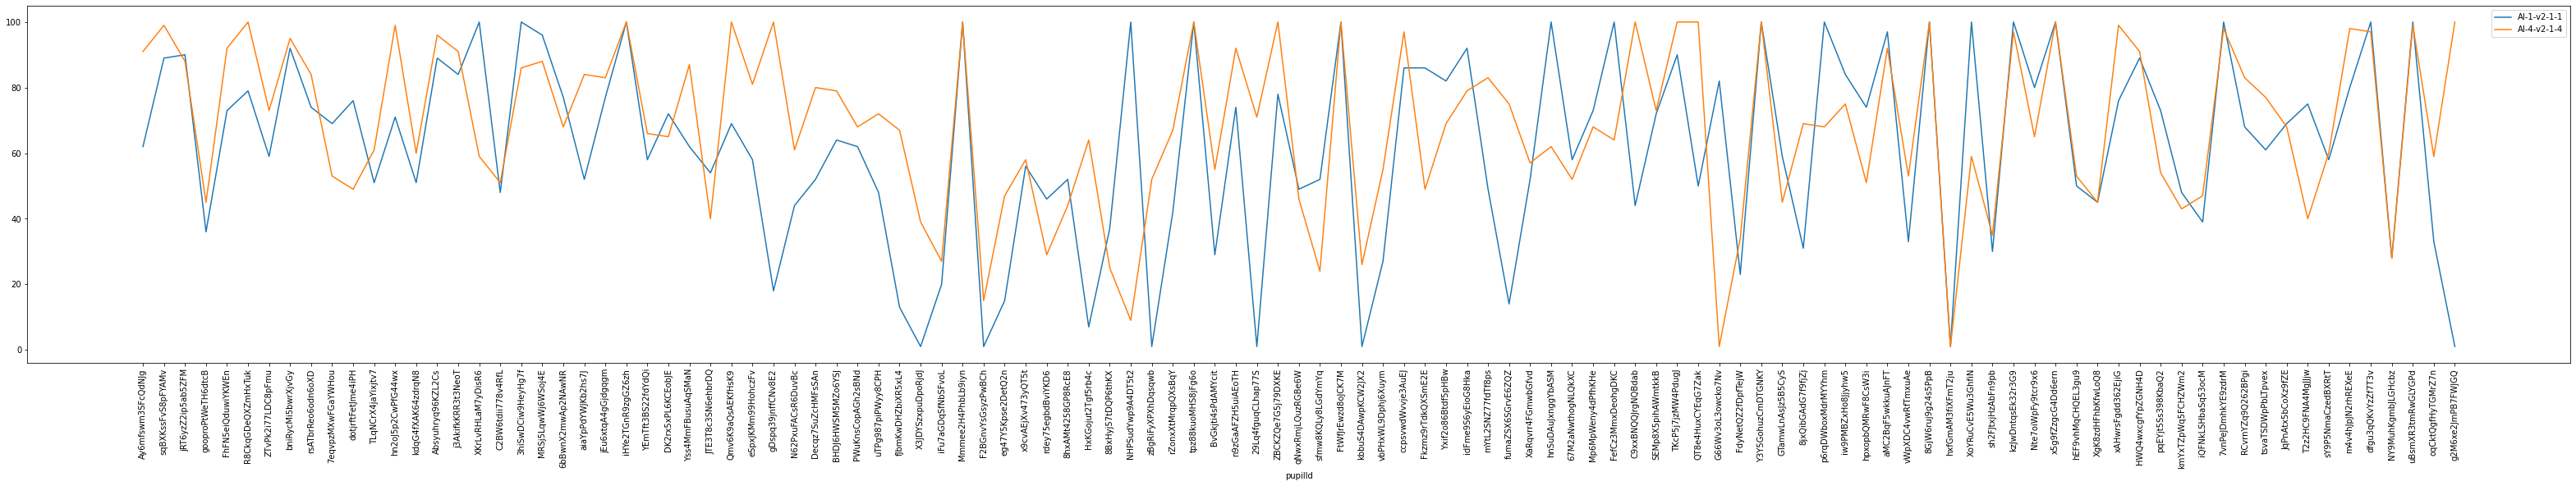

-----Average Improvements & je SuS T0.5-T1-----


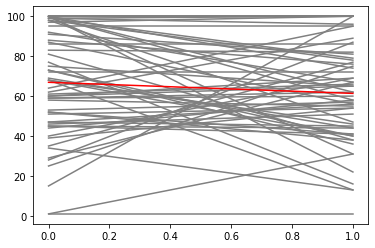

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


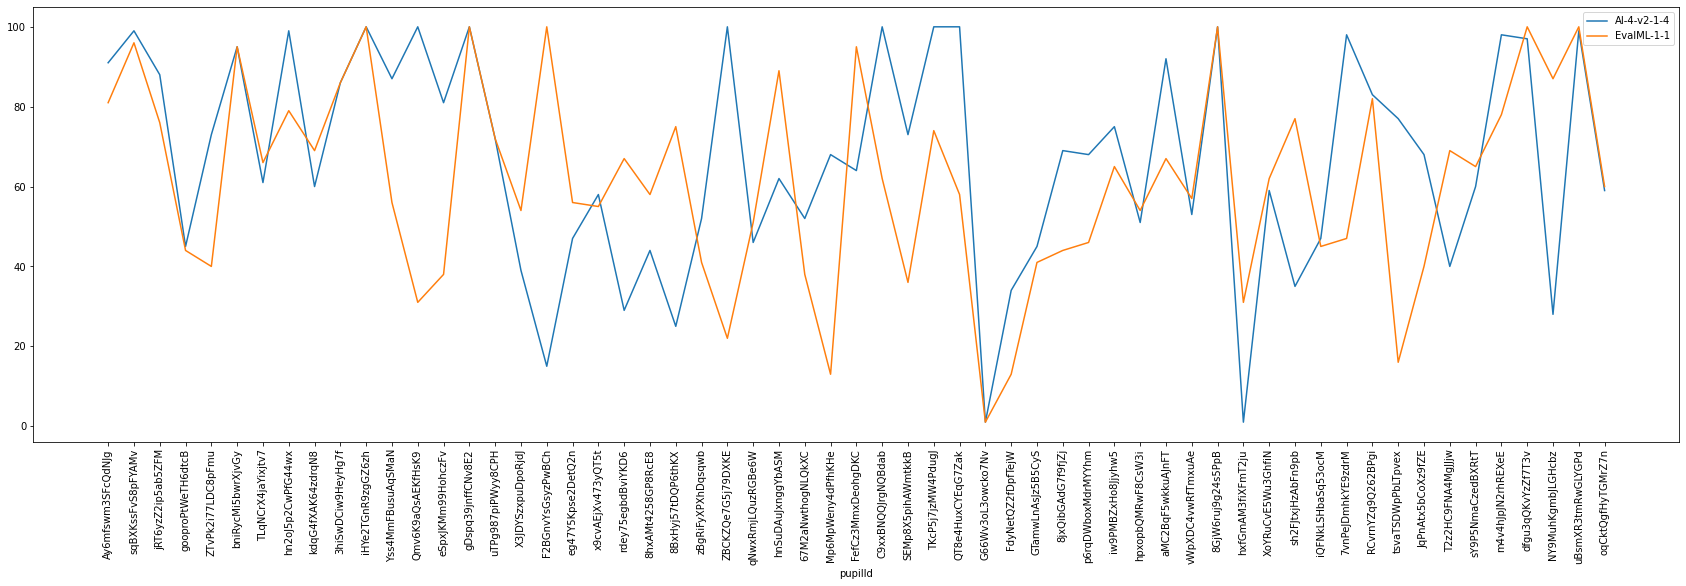

-----Average Improvements & je SuS T0-T1-----


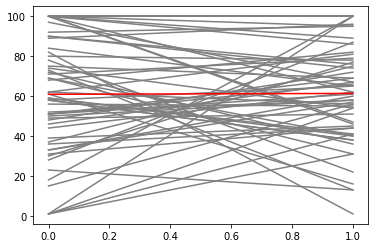

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


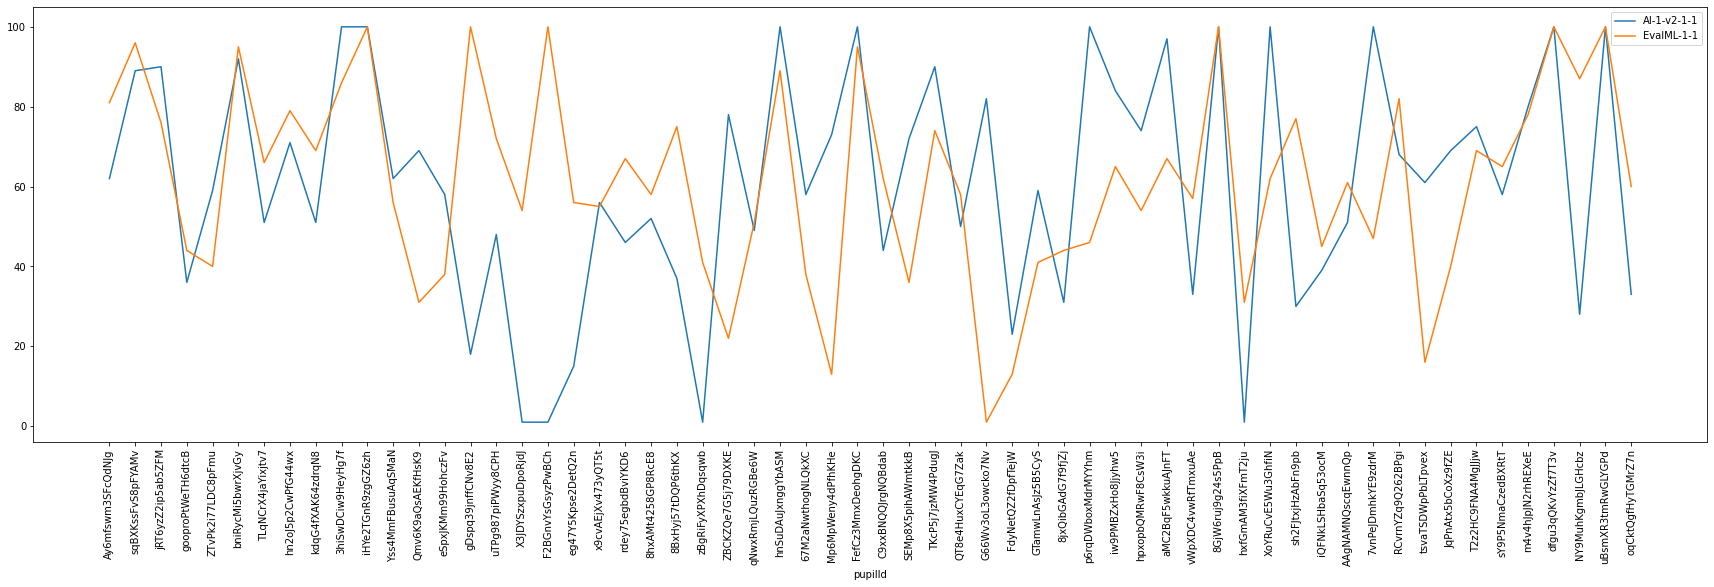

In [6]:
print("-------Mit allen Daten------")
surveySliderStatistics(pupil_performance_df["AI-1-v2-1-1"])
surveySliderStatistics(pupil_performance_df["AI-4-v2-1-4"])
surveySliderStatistics(pupil_performance_df["EvalML-1-1"])
pupil_performance_df.boxplot(column=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])
plt.show()
pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1']).boxplot(column=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])
plt.show()

print()
print("-------Nur mit vollständigen Daten------")
surveySliderStatistics(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-1-v2-1-1"])
surveySliderStatistics(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-4-v2-1-4"])
surveySliderStatistics(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["EvalML-1-1"])
pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1']).boxplot(column=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])
plt.show()

print()


'''
print("Nach Klasse bei T0")
pupil_performance_df.groupby("classId")["AI-1-v2-1-1"].plot.kde()
plt.show()
'''

print("-----Average Improvements & je SuS T0-T0.5-----")
plot_improvements(pupil_performance_df[["AI-1-v2-1-1","AI-4-v2-1-4"]])
print("-----Average Improvements & je SuS T0.5-T1-----")
plot_improvements(pupil_performance_df[["AI-4-v2-1-4","EvalML-1-1"]])
print("-----Average Improvements & je SuS T0-T1-----")
plot_improvements(pupil_performance_df[["AI-1-v2-1-1","EvalML-1-1"]])


#### Was ist KI - Selbsteinschätzung - Test auf Normalverteilung
* wenn Daten normalverteilt sind --> gepaarte t-Test ist ein t-Test für 2 Stichproben, die voneinander abhängig sind
  * Voraussetzung für die Anwendung des gepaarten t-Tests ist, dass die Differenzen der gepaarten Daten – normalverteilt sind (samplesize must be at least 20 for one normality test in python). 60 SuS --> gilt
* wenn daten nicht normalverteilt: Wilcoxon signed rank test

In [7]:
# Paarweise differenzen berechnen
differences_0_05 = calculateDifferences(pupil_performance_df[["AI-4-v2-1-4", "AI-1-v2-1-1"]])
differences_05_1 = calculateDifferences(pupil_performance_df[["EvalML-1-1", "AI-4-v2-1-4"]])
differences_0_1 = calculateDifferences(pupil_performance_df[["EvalML-1-1", "AI-1-v2-1-1"]])

#stat, p = stats.shapiro(differences)
print("\n-----Test auf Normalverteilung-----")
print(stats.shapiro(differences_0_05))
print(stats.shapiro(differences_05_1))
print(stats.shapiro(differences_0_1))


-----Test auf Normalverteilung-----
ShapiroResult(statistic=0.9526786208152771, pvalue=0.0006073114927858114)
ShapiroResult(statistic=0.9679651856422424, pvalue=0.12192942202091217)
ShapiroResult(statistic=0.9806115031242371, pvalue=0.4549465775489807)


If the p value is less than our alpha (significance value), we can reject the hypothesis that this sample data is normally distributed. If greater, we cannot reject the null hypothesis and must conclude the data is normally distributed. 

p-values shapiro:
* 0.0006 --> können NH verwerfen, das normalverteilt --> nicht normalverteilt --> wilcoxon signed rank test
* 0.12 --> können NH das normalvert ist nicht verwerfen --> gepaarter t-test & vllt wilcoxon signed rank
* 0.45 --> können NH das normalvert ist nicht verwerfen --> gepaarter t-test & vllt wilcoxon signed rank

#### Was ist KI - Selbsteinschätzung - Signifikanztest


In [14]:
print("-----Wilcoxon-----")
print(stats.wilcoxon(differences_0_05))
print(stats.wilcoxon(differences_05_1))
print(stats.wilcoxon(differences_0_1))

print("\n-----Korrekte Analyse-----")
print(stats.wilcoxon(differences_0_05))
print(stats.ttest_rel(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-4-v2-1-4"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["EvalML-1-1"]))
print(stats.ttest_rel(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-1-v2-1-1"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["EvalML-1-1"]))

print("\n-----Effektstärken-----")
print(cohen_d(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-1-v2-1-1"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-4-v2-1-4"]))
#print(print(cohen_d(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-4-v2-1-4"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["EvalML-1-1"])))
#print(print(cohen_d(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-1-v2-1-1"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["EvalML-1-1"])))


-----Wilcoxon-----
WilcoxonResult(statistic=1755.0, pvalue=0.005437282165958155)
WilcoxonResult(statistic=527.5, pvalue=0.1412654329095244)
WilcoxonResult(statistic=795.0, pvalue=0.9804734656205535)

-----Korrekte Analyse-----
WilcoxonResult(statistic=1755.0, pvalue=0.005437282165958155)
Ttest_relResult(statistic=1.4189404188314818, pvalue=0.16126815014118778)
Ttest_relResult(statistic=-0.062161081908979274, pvalue=0.9506482755564919)

-----Effektstärken-----
-0.20696290149957172


Ergebnisse:
* von 0 nach 05:
  * sehr kleines p (0.005) --> your data are unlikely with a true null --> null, dass sie von der gleichen population kommen also unwahrscheinlich --> signifikantes ergebnis, dass es einen effekt gab
  * effektstärke: 0.2069 --> schwacher effekt
* von 05 nach 1:
  * wilcoxon:
    * p (0.14) --> daten sind wahrscheinlich mit null hypothese, dass sie von gleicher population kommen --> Kein Effekt gefunden
    * daher keine effektstärke
  * gepaarter T-Test:
    * p 0.16 --> keine signifikanz
* von 0 nach 1:
  * wilcoxon: großes p 0.98 --> können null hypothese nicht verwerfen --> keine beweise für effekt
  * gepaarter T-test: p 0.950 --> können NH nicht verwerfen --> kein beweis für effekt
  * keine signifikanz --> keine effektstärke berechnen

### 1.2 Freitext zu "Was ist KI"

#### 1.2.1 Teacher Rating

* T0: AI-1-v2-1-2
* T1: 'AI-4-v2-1-3'

In [29]:
surveySliderStatistics(pupil_performance_df["AI-1-v2-1-2_rating_content"])
surveySliderStatistics(pupil_performance_df["AI-4-v2-1-3_rating_content"])

differences_content = calculateDifferences(pupil_performance_df[["AI-4-v2-1-3_rating_content", "AI-1-v2-1-2_rating_content"]])

print(stats.shapiro(differences_content))
print(stats.wilcoxon(differences_content))
#print(stats.ttest_rel(pupil_performance_df.dropna(subset=["AI-4-v2-1-3_rating_content", "AI-1-v2-1-2_rating_content"])["AI-1-v2-1-2_rating_content"], pupil_performance_df.dropna(subset=["AI-4-v2-1-3_rating_content", "AI-1-v2-1-2_rating_content"])["AI-4-v2-1-3_rating_content"]))

AI-1-v2-1-2_rating_content
Q1: 4.0 and Q3: 5.0
median: 5.0
mean: 4.168421052631579
std: 1.1
min: 0.0 und max: 5.0

AI-4-v2-1-3_rating_content
Q1: 3.0 and Q3: 5.0
median: 4.0
mean: 3.951219512195122
std: 1.32
min: 0.0 und max: 5.0

ShapiroResult(statistic=0.9061924815177917, pvalue=1.807722946978174e-05)
WilcoxonResult(statistic=355.5, pvalue=0.14127361343004882)


results:
* normality test: 1.807722946978174e-05 --> reject NH --> daten nicht normalverteilt
* wilcoxon: pvalue ist 0.1412 --> your data are likely with a true null --> null war: observed difference in the sample does not reflect a true difference between populations --> keine beweise dafür, dass das Paket einen Effekt auf die content ratings hatten

Teacher Ratings ignorieren!


#### 1.2.2.1 Was ist KI - Freitext  - nullanswers und unknown

Unknown ist True, wenn:
* die SuS explizit sagen, dass sie es nicht wissen

Nullanswers sind True, wenn keine Aussage über deren Wissensstand gemacht werden kann, zB weil:
* sie nichts/Quatsch ("." / "osdhsl") abgeben oder nicht auf die frage antworten ("lul" etc)
* offensichtliche Plagiate (gelten nur, wenn der genaue Wortlaut ergoogelt werden konnte)

In [52]:
print("-----Anzahl Abgaben-----")
#print("T0: ", len(pupil_performance_df_rated[['AI-1-v2-1-2_correct_points']].dropna()))
#print("T1: ", len(pupil_performance_df_rated[['AI-4-v2-1-3_correct_points']].dropna()))
print("T0: ", len(pupil_performance_df_rated['AI-1-v2-1-2_null_answer'].dropna()))
print("T0: ", len(pupil_performance_df_rated['AI-4-v2-1-3_null_answer'].dropna()))
print("-----'Anzahl Ich weiß es nicht-Abgaben'-----")
print("T0: ", len(pupil_performance_df_rated[pupil_performance_df_rated['AI-1-v2-1-2_unknown']==True]))
print("T1: ", len(pupil_performance_df_rated[pupil_performance_df_rated['AI-4-v2-1-3_unknown']==True]))
print("-----Anzahl Leerabgaben und Plagiate-----")
print("T0: ", len(pupil_performance_df_rated[pupil_performance_df_rated['AI-1-v2-1-2_null_answer']==True]))
print("T1: ", len(pupil_performance_df_rated[pupil_performance_df_rated['AI-4-v2-1-3_null_answer']==True]))

proportionT0unknown = pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[True].values[0])
proportionT1unknown = pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[True].values[0])
proportionT0null = pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[True].values[0])
proportionT1null = pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[True].values[0])

print("\n-----Veränderung der Anteile-----")
print("Proportion Unknown: ", round(proportionT0unknown*100, 2), "-->", round(proportionT1unknown*100,2))
print("Proportion Nullanswers: ", round(proportionT0null*100,2), "-->", round(proportionT1null*100,2), "\n")


-----Anzahl Abgaben-----
T0:  141
T0:  111
-----'Anzahl Ich weiß es nicht-Abgaben'-----
T0:  2
T1:  3
-----Anzahl Leerabgaben und Plagiate-----
T0:  14
T1:  13

-----Veränderung der Anteile-----
Proportion Unknown:  1.42 --> 2.7
Proportion Nullanswers:  9.93 --> 11.71 



In [24]:
#Signifikanz der Veränderungen der Populationsverhältnisse
print("-----Signifikanz mittels Proportions-z-Test-----")
countUn = np.array([pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[True].values[0], pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[True].values[0]])
nobsUn = np.array([(pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[True].values[0]), (pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[True].values[0])])
statUn, pvalUn = proportions_ztest(countUn, nobsUn)
print("Unknown --> stat: ", statUn, " pval", pvalUn)

countNu = np.array([pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[True].values[0], pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[True].values[0]])
nobsNu = np.array([(pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[True].values[0]), (pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[True].values[0])])
statNu, pvalNu = proportions_ztest(countNu, nobsNu)
print("Nullanswers --> stat: ", statNu, " pval", pvalNu)

-----deskriptiv-----
Proportion Unknown:  1.42 --> 2.7
Proportion Nullanswers:  9.93 --> 11.71 

-----Signifikanz mittels Proportions-z-Test-----
Unknown --> stat:  -0.7257579524607306  pval 0.4679871677810682
Nullanswers --> stat:  -0.4542137601693293  pval 0.6496749800717339


keine signifikanz
und in relativen werten kleine (aber nicht signifikante) verschlechterung - kann daran liegen, dass fast alle SuS schon eine meinung zur KI haben.

#### 1.2.2 Was ist KI - Freitext - Desktipriv
##### Korrekte, Inkorrekte und Irrelevante Punkte vorher und nachher

In [128]:
print("-----correct points-----")
surveySliderStatistics(pupil_performance_df_rated["AI-1-v2-1-2_correct_points"])
surveySliderStatistics(pupil_performance_df_rated["AI-4-v2-1-3_correct_points"])

print("\n-----incorrect points-----")
surveySliderStatistics(pupil_performance_df_rated["AI-1-v2-1-2_incorrect_points"])
surveySliderStatistics(pupil_performance_df_rated["AI-4-v2-1-3_incorrect_points"])

print("\n-----irrelevant points-----")
surveySliderStatistics(pupil_performance_df_rated["AI-1-v2-1-2_irrelevant_points"])
surveySliderStatistics(pupil_performance_df_rated["AI-4-v2-1-3_irrelevant_points"])

#TODO: vllt lieber als df ausgeben und immer nur mean und std zu beiden zeitpunkten gegenüberstellen!

-----correct points-----
AI-1-v2-1-2_correct_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.6850393700787402
std: 0.97
min: 0.0 und max: 7.0

AI-4-v2-1-3_correct_points
Q1: 0.0 and Q3: 3.0
median: 1.0
mean: 1.8775510204081634
std: 1.76
min: 0.0 und max: 6.0


-----incorrect points-----
AI-1-v2-1-2_incorrect_points
Q1: 0.0 and Q3: 1.0
median: 1.0
mean: 0.616
std: 0.56
min: 0.0 und max: 2.0

AI-4-v2-1-3_incorrect_points
Q1: 0.0 and Q3: 0.0
median: 0.0
mean: 0.22105263157894736
std: 0.42
min: 0.0 und max: 1.0


-----irrelevant points-----
AI-1-v2-1-2_irrelevant_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.368
std: 0.56
min: 0.0 und max: 2.0

AI-4-v2-1-3_irrelevant_points
Q1: 0.0 and Q3: 0.0
median: 0.0
mean: 0.18947368421052632
std: 0.39
min: 0.0 und max: 1.0



#### Streuung der Anzahl richtiger Punkte

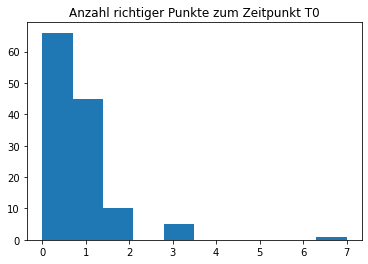

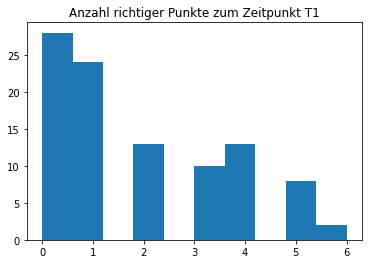

In [28]:
plt.hist(pupil_performance_df_rated["AI-1-v2-1-2_correct_points"].dropna())
plt.title("Anzahl richtiger Punkte zum Zeitpunkt T0")
plt.show()
plt.hist(pupil_performance_df_rated["AI-4-v2-1-3_correct_points"].dropna())
plt.title("Anzahl richtiger Punkte zum Zeitpunkt T1")
plt.show()

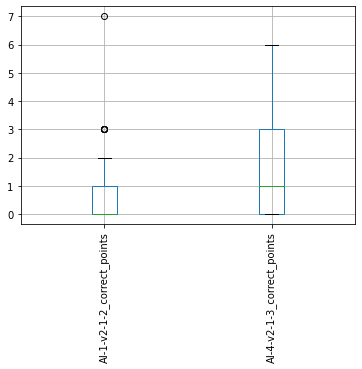

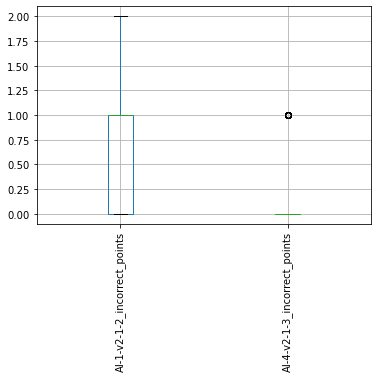

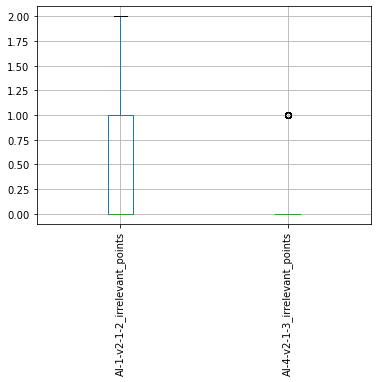

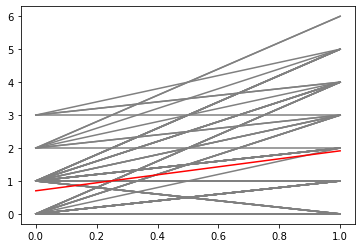

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


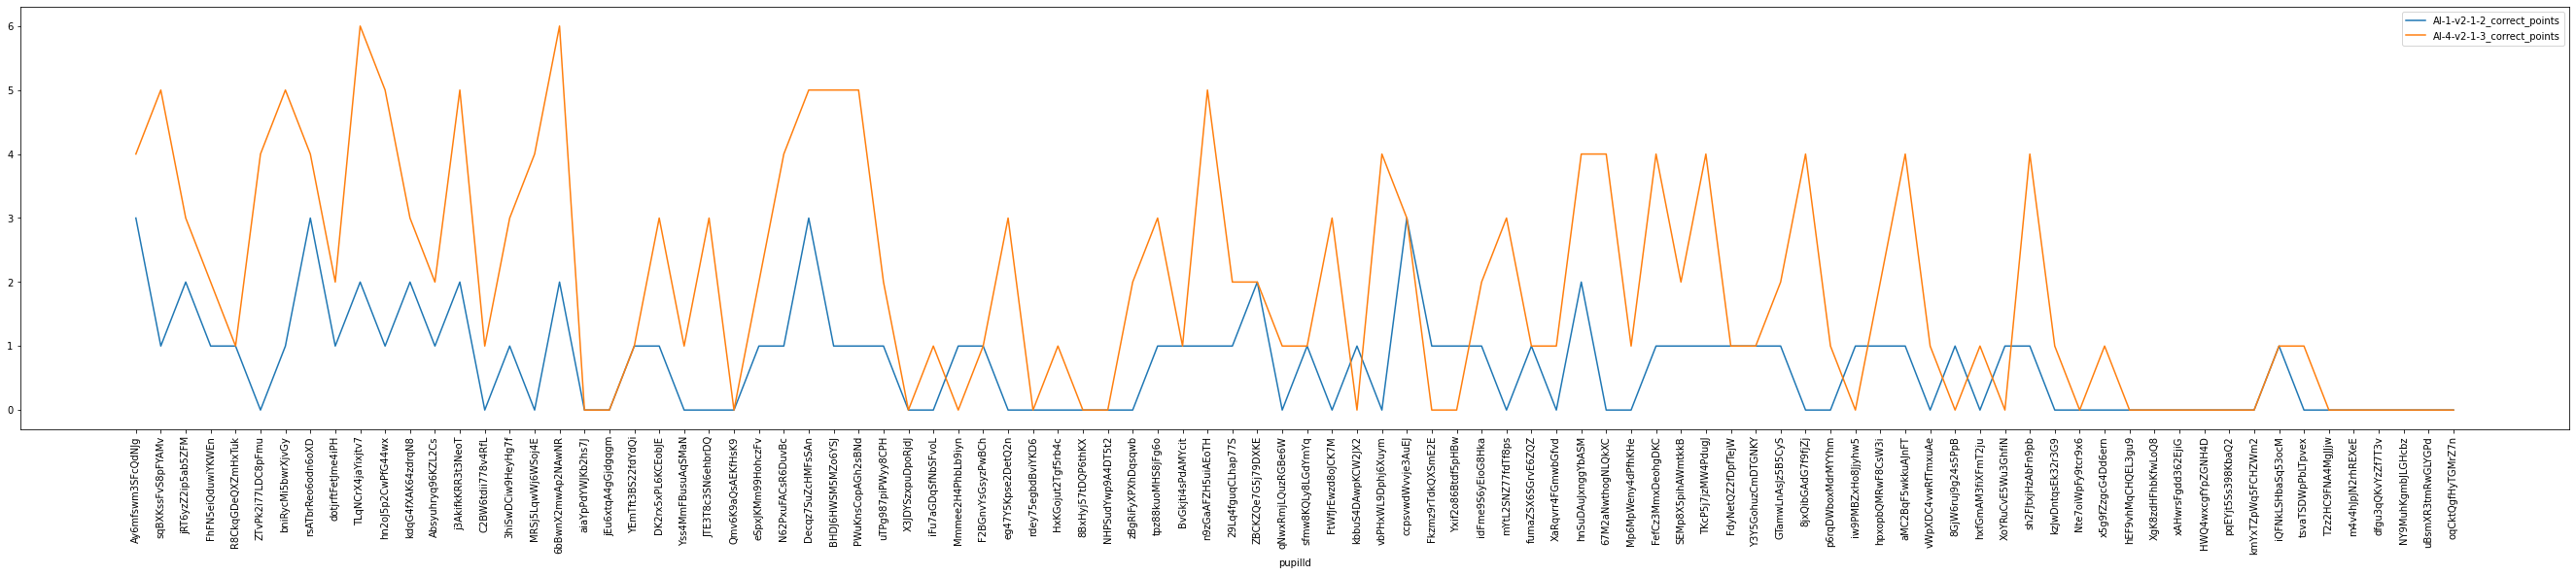

In [129]:
pupil_performance_df_rated.boxplot(column=["AI-1-v2-1-2_correct_points", "AI-4-v2-1-3_correct_points"])
plt.xticks(rotation = 90)
plt.show()

pupil_performance_df_rated.boxplot(column=['AI-1-v2-1-2_incorrect_points', "AI-4-v2-1-3_incorrect_points"])
plt.xticks(rotation = 90)
plt.show()

pupil_performance_df_rated.boxplot(column=['AI-1-v2-1-2_irrelevant_points', "AI-4-v2-1-3_irrelevant_points"])
plt.xticks(rotation = 90)
plt.show()

#pupil_performance_df_rated.boxplot(column=["AI-1-v2-1-2_correct_points", 'AI-1-v2-1-2_incorrect_points', 'AI-1-v2-1-2_irrelevant_points', "AI-4-v2-1-3_correct_points", "AI-4-v2-1-3_incorrect_points", "AI-4-v2-1-3_irrelevant_points"])
#plt.xticks(rotation = 90)
#plt.show()

plot_improvements(pupil_performance_df_rated[["AI-1-v2-1-2_correct_points", "AI-4-v2-1-3_correct_points"]])
#plot_improvements(pupil_performance_df_rated[["AI-1-v2-1-2_incorrect_points", "AI-4-v2-1-3_incorrect_points"]])
#plot_improvements(pupil_performance_df_rated[["AI-1-v2-1-2_irrelevant_points", "AI-4-v2-1-3_irrelevant_points"]])
#zu wenige inkorrekte und irrelevante, damit die grafik gut aussieht

#### 1.2.2 Was ist KI - Freitext - Signifikanz und Effektstärke

In [130]:
# AI-1-v2-1-2, AI-4-v2-1-3
KIdifferences_correct = calculateDifferences(pupil_performance_df_rated[["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"]])
KIdifferences_incorrect = calculateDifferences(pupil_performance_df_rated[["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"]])
KIdifferences_irrelevant = calculateDifferences(pupil_performance_df_rated[["AI-4-v2-1-3_irrelevant_points", "AI-1-v2-1-2_irrelevant_points"]])

print("-----Shapiro-----")
print(stats.shapiro(KIdifferences_correct))
print(stats.shapiro(KIdifferences_incorrect))
print(stats.shapiro(KIdifferences_irrelevant))

-----Shapiro-----
ShapiroResult(statistic=0.8644287586212158, pvalue=8.662321704377973e-08)
ShapiroResult(statistic=0.8164995312690735, pvalue=2.8508673199922896e-09)
ShapiroResult(statistic=0.7312315702438354, pvalue=1.3009998460489225e-11)


* alle p unter 0.05 --> reject NH --> keine normalverteilt

In [131]:
print("-----Signifikanz-----")
print(stats.wilcoxon(KIdifferences_correct))
print(stats.wilcoxon(KIdifferences_incorrect))
print(stats.wilcoxon(KIdifferences_irrelevant))
#print(stats.ttest_rel(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_irrelevant_points", 'AI-1-v2-1-2_irrelevant_points'])["AI-1-v2-1-2_irrelevant_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_irrelevant_points", 'AI-1-v2-1-2_irrelevant_points'])["AI-4-v2-1-3_irrelevant_points"]))

-----Signifikanz-----
WilcoxonResult(statistic=122.5, pvalue=5.919715417692041e-10)
WilcoxonResult(statistic=123.0, pvalue=1.5945871800686743e-06)
WilcoxonResult(statistic=84.0, pvalue=0.003621577001001229)


Ergebnisse:
  * sehr signifikantes ergebnis für korrekte: nehmen zu (was gibt effektstärke hier an?)
  * sehr signifikantes für inkorrekte: nehmen ab
  * signifikant bzw 0.0018 für irrelevante, nehmen ab

In [132]:
print("\n-----Effektstärke-----")
#print(cohen_d(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-4-v2-1-3_correct_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-1-v2-1-2_correct_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-1-v2-1-2_correct_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-4-v2-1-3_correct_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"])["AI-1-v2-1-2_incorrect_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"])["AI-4-v2-1-3_incorrect_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_irrelevant_points", 'AI-1-v2-1-2_irrelevant_points'])["AI-1-v2-1-2_irrelevant_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_irrelevant_points", 'AI-1-v2-1-2_irrelevant_points'])["AI-4-v2-1-3_irrelevant_points"]))


-----Effektstärke-----
-0.8803577784139401
0.773017651715653
0.4149060651860154


Ergebnisse Effektstärke:
* korrekte: -0.8803577784139401 → sehr starker effekt
* inkorrekte: 0.773017651715653 → starker effekt
* irrelevante: 0.4149060651860154 → (schwacher) bis mittlerer effekt


##### Gibt es Unterschiede zwischen den Klassen?

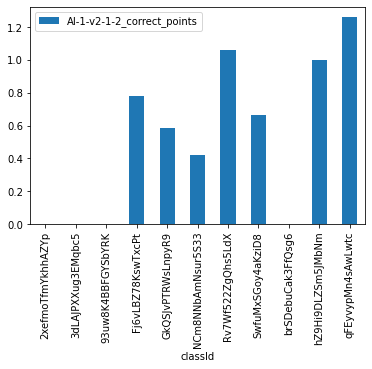

In [133]:
pupil_performance_df_rated.groupby("classId")[["AI-1-v2-1-2_correct_points"]].agg(np.mean).plot.bar()
plt.show()

Manche Klassen haben schon etwas über KI gelernt. zB in "qFEyvypMn4sAwLwtc" wurde oft Deep Learning referenziert und teilweise sogar erklärt.

##### Lernfortschritt nach Klasse

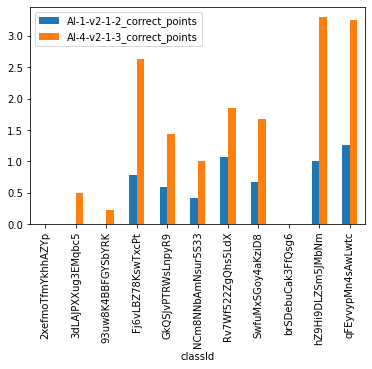

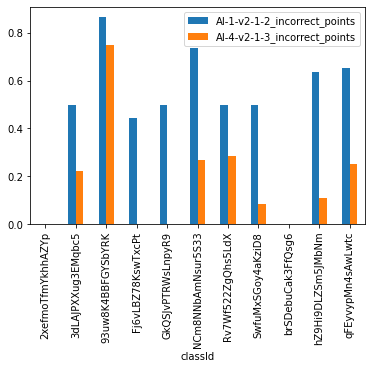

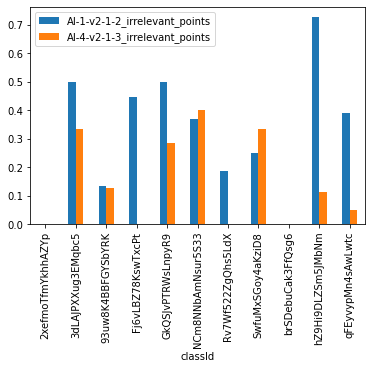

In [134]:
pupil_performance_df_rated.groupby("classId")[["AI-1-v2-1-2_correct_points", "AI-4-v2-1-3_correct_points"]].agg(np.mean).plot(y=["AI-1-v2-1-2_correct_points", "AI-4-v2-1-3_correct_points"], kind="bar")
plt.show() # der ist eine gute veranschaulichung, dass sie etwas gelernt haben
pupil_performance_df_rated.groupby("classId")[["AI-1-v2-1-2_incorrect_points", "AI-4-v2-1-3_incorrect_points"]].agg(np.mean).plot(y=["AI-1-v2-1-2_incorrect_points", "AI-4-v2-1-3_incorrect_points"], kind="bar")
plt.show() #der ist okay
pupil_performance_df_rated.groupby("classId")[["AI-1-v2-1-2_irrelevant_points", "AI-4-v2-1-3_irrelevant_points"]].agg(np.mean).plot(y=["AI-1-v2-1-2_irrelevant_points", "AI-4-v2-1-3_irrelevant_points"], kind="bar")
plt.show() #der ist egal


Trotz unterschiedlichem Startpunkt scheinen alle Klassen zu lernen

### 1.3 Was ist KI - MC
#### 1.3.1 Was ist KI - MC - KI-Anwendung erkennen

In [73]:
analyse_mc(["AI-2-v2-1-1"], 4)

AI-2-v2-1-1
Kannst du erkennen, wo KI überall drin steckt? Denke dabei an die Eigenschaften, die alle KI-Anwendungen verbindet. Bei Multiple-Choice Aufgaben, neben denen “Mehrfachauswahl” steht, können mehrere Antworten richtig sein. Wähle alle richtigen Antworten aus. Wenn du mal nicht weiter weißt, kannst du dir auch einen Tipp holen.
*Der Newsfeed eines Social Network nutzt KI - True
*Die Personalisierung einer Google-Anfrage nutzt KI - True
*Die Startseite einer Webseite, die jedem Besucher die gleichen Inhalte anzeigt nutzt KI - False
*Gesichtserkennung nutzt KI - True
[True, True, False, True]


Average number of errors: 1.1068702290076335
Expected number of errors with guessing:  2.0


In [79]:
analyse_mc(["EvalML-1-4"], 4)

EvalML-1-4
Welche der folgenden Anwendungen enthalten KI-Methoden?
*Die Erkennung von Gegenständen auf Bildern - True
*Das Sortieren von Bildern nach Datum - False
*Ein personalisiertes Empfehlungssystem für Musik - True
*Eine Nachrichtenseite, die jedem Nutzer den gleichen Inhalt präsentiert - False
[True, False, True, False]


Average number of errors: 0.8194444444444444
Expected number of errors with guessing:  2.0


#### 1.3.2 Was ist KI? - MC - Definition KI

In [76]:
print_mc(["AI-4-v2-1-2"])
analyse_partial_mc("AI-4-v2-1-2", 1, 2);

AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?
*KI-Anwendungen treffen eigenständige Entscheidungen - True
*KI-Anwendungen lernen durch Erfahrung - True
*Intelligentes Verhalten setzt allgemeine Intelligenz voraus - False
*Heutige KI-Anwendungen gehören alle zur spezifischen KI - True
*Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen - True
*Ein Spam-Filter ist eine allgemeinen KI - False
*Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht - True
[True, True, False, True, True, False, True]

Average number errors in task  AI-4-v2-1-2 :  0.7747747747747747
Expected number errors in task  AI-4-v2-1-2 :  1.0


In [77]:
print_mc(["EvalML-1-3"])
analyse_partial_mc("EvalML-1-3", 1, 3);

EvalML-1-3
Welche der Aussagen stimmen?
*KI-Anwendungen zeichnen sich dadurch aus, dass sie intelligentes Verhalten zeigen, autonom funktionieren und mit Erfahrung lernen - True
*Eine fertige KI-Anwendung kann nicht ohne Hilfe von einem Menschen funktionieren - False
*Eine fertige KI-Anwendung kann nicht mit Erfahrung lernen, sie bleibt, wie sie ist - False
*Eine spezifische KI zeigt intelligentes Verhalten in einem kleinen Bereich - True
*Jede KI hat allgemeine Intelligenz. Damit ist jede KI eine allgemeine KI - False
*Ein Programm, dass so gut Schach spielen kann, wie Menschen, ist ein Beispiel für eine spezifische KI - True
*Derzeit gibt es sowohl Anwendungen, die zur spezifischen, als auch welche, die zur allgemeinen KI gehören - False
*KI kann irgendwann alles besser als der Mensch - False
*Jeder Mensch wird zukünftig eine Vielzahl verschiedener KIs in seinem Alltag nutzen - True
[True, False, False, True, False, True, False, False, True]

Average number errors in task  EvalML-1-3

## 2. Unterschied spezifisch und allgemeine KI
### 2.1 Selbsteinschätzungen
<b>Hier gibt es keinen T0, nur T0.5 und T1</b>

In [10]:
print(len(pupil_performance_df["AI-4-v2-1-5"].dropna()))

111


AI-4-v2-1-5
Q1: 42.0 and Q3: 89.0
median: 60.0
mean: 61.06306306306306
std: 29.92
min: 1.0 und max: 100.0

EvalML-1-2
Q1: 47.75 and Q3: 83.25
median: 59.5
mean: 62.375
std: 27.06
min: 1.0 und max: 100.0



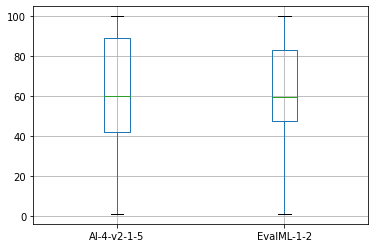

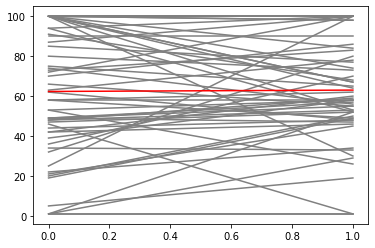

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


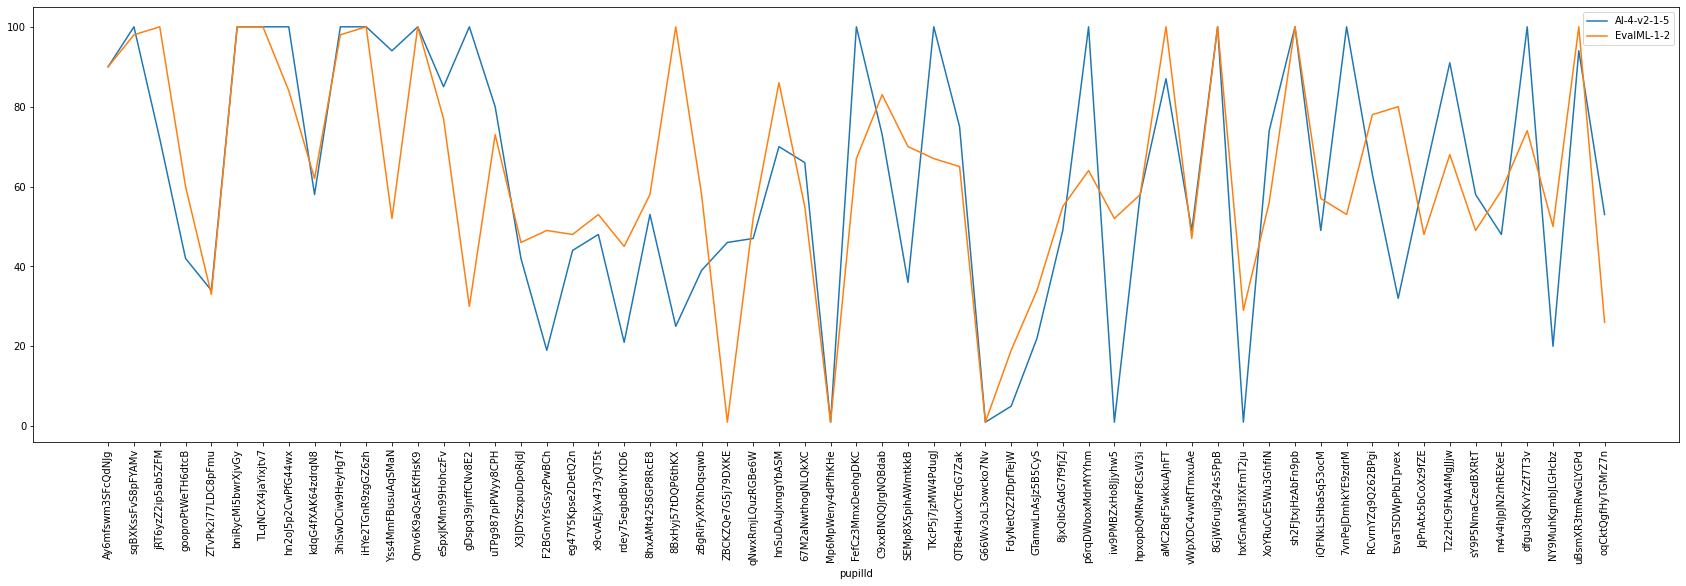

In [35]:
surveySliderStatistics(pupil_performance_df["AI-4-v2-1-5"])
surveySliderStatistics(pupil_performance_df["EvalML-1-2"])

pupil_performance_df.boxplot(column=['AI-4-v2-1-5', 'EvalML-1-2'])
plt.show()

plot_improvements(pupil_performance_df[['AI-4-v2-1-5', 'EvalML-1-2']])

### 2.2 spezifische vs allgemein KI - MCs

#### 2.2.1 spezifische vs allgemein KI - MCs - KI-Art erkennen

In [99]:
analyse_mc(['AI-3-v2-1-2'], 3)

AI-3-v2-1-2
Welche der Aussagen über KI-Anwendungen stimmen?
*Empfehlungssysteme gehören zur spezifischen KI - True
*Programme zur Bilderkennung gehören zur allgemeinen KI - False
*Eine KI aus einem Film, die eigenständige Entscheidungen trifft, mit Menschen spricht und sich am Ende gegen sie wendet, gehört zur allgemeinen KI - True
[True, False, True]


Average number of errors: 1.3548387096774193
Expected number of errors with guessing:  1.5


In [95]:
print_mc(["AI-4-v2-1-2"])
analyse_partial_mc("AI-4-v2-1-2", 6, 6);

AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?
*KI-Anwendungen treffen eigenständige Entscheidungen - True
*KI-Anwendungen lernen durch Erfahrung - True
*Intelligentes Verhalten setzt allgemeine Intelligenz voraus - False
*Heutige KI-Anwendungen gehören alle zur spezifischen KI - True
*Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen - True
*Ein Spam-Filter ist eine allgemeinen KI - False
*Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht - True
[True, True, False, True, True, False, True]

Average number errors in task  AI-4-v2-1-2 :  0.26126126126126126
Expected number errors in task  AI-4-v2-1-2 :  0.5


In [97]:
print_mc(["EvalML-1-3"])
analyse_partial_mc("EvalML-1-3", 6, 6);

EvalML-1-3
Welche der Aussagen stimmen?
*KI-Anwendungen zeichnen sich dadurch aus, dass sie intelligentes Verhalten zeigen, autonom funktionieren und mit Erfahrung lernen - True
*Eine fertige KI-Anwendung kann nicht ohne Hilfe von einem Menschen funktionieren - False
*Eine fertige KI-Anwendung kann nicht mit Erfahrung lernen, sie bleibt, wie sie ist - False
*Eine spezifische KI zeigt intelligentes Verhalten in einem kleinen Bereich - True
*Jede KI hat allgemeine Intelligenz. Damit ist jede KI eine allgemeine KI - False
*Ein Programm, dass so gut Schach spielen kann, wie Menschen, ist ein Beispiel für eine spezifische KI - True
*Derzeit gibt es sowohl Anwendungen, die zur spezifischen, als auch welche, die zur allgemeinen KI gehören - False
*KI kann irgendwann alles besser als der Mensch - False
*Jeder Mensch wird zukünftig eine Vielzahl verschiedener KIs in seinem Alltag nutzen - True
[True, False, False, True, False, True, False, False, True]

Average number errors in task  EvalML-1-3

##### Definitionen spezifische vs allgemeine KI

In [96]:
print_mc(["AI-4-v2-1-2"])
analyse_partial_mc("AI-4-v2-1-2", 5, 5);

AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?
*KI-Anwendungen treffen eigenständige Entscheidungen - True
*KI-Anwendungen lernen durch Erfahrung - True
*Intelligentes Verhalten setzt allgemeine Intelligenz voraus - False
*Heutige KI-Anwendungen gehören alle zur spezifischen KI - True
*Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen - True
*Ein Spam-Filter ist eine allgemeinen KI - False
*Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht - True
[True, True, False, True, True, False, True]

Average number errors in task  AI-4-v2-1-2 :  0.38738738738738737
Expected number errors in task  AI-4-v2-1-2 :  0.5


In [82]:
print_mc(["EvalML-1-3"])
analyse_partial_mc("EvalML-1-3", 4, 5);

EvalML-1-3
Welche der Aussagen stimmen?
*KI-Anwendungen zeichnen sich dadurch aus, dass sie intelligentes Verhalten zeigen, autonom funktionieren und mit Erfahrung lernen - True
*Eine fertige KI-Anwendung kann nicht ohne Hilfe von einem Menschen funktionieren - False
*Eine fertige KI-Anwendung kann nicht mit Erfahrung lernen, sie bleibt, wie sie ist - False
*Eine spezifische KI zeigt intelligentes Verhalten in einem kleinen Bereich - True
*Jede KI hat allgemeine Intelligenz. Damit ist jede KI eine allgemeine KI - False
*Ein Programm, dass so gut Schach spielen kann, wie Menschen, ist ein Beispiel für eine spezifische KI - True
*Derzeit gibt es sowohl Anwendungen, die zur spezifischen, als auch welche, die zur allgemeinen KI gehören - False
*KI kann irgendwann alles besser als der Mensch - False
*Jeder Mensch wird zukünftig eine Vielzahl verschiedener KIs in seinem Alltag nutzen - True
[True, False, False, True, False, True, False, False, True]

Average number errors in task  EvalML-1-3

#### 2.2.2 spezifische vs allgemein KI - MCs - Intelligenz / definition

In [89]:
analyse_combined_mcs("AI-4-v2-1-1", "AI-4-v2-1-2", 1, 4, 3, 3)

AI-4-v2-1-1
Was bedeuten diese Unterscheidung zwischen spezifischer und allgemeiner KI jetzt für die Intelligenz von KI-Anwendungen?
*KI-Anwendungen sind allgemein intelligent - False
*KI-Anwendungen zeigen intelligentes Verhalten in einem kleinen Bereich - True
*Intelligentes Verhalten in einem spezifischen Bereich muss nicht gleich allgemeine Intelligenz bedeuten - True
*Eine KI, die sich in einem einzigen Bereich so intelligent verhält wie ein Mensch, muss allgemeine Intelligenz besitzen - False
[False, True, True, False]

Average number errors in task  AI-4-v2-1-1 :  1.3693693693693694
Expected number errors in task  AI-4-v2-1-1 :  2.0

-------------------
AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?
*KI-Anwendungen treffen eigenständige Entscheidungen - True
*KI-Anwendungen lernen durch Erfahrung - True
*Intelligentes Verhalten setzt allgemeine Intelligenz voraus - False
*Heutige KI-Anwendungen gehören alle zur spezifischen KI - True

##### allgemeine KI gibt es noch nicht

In [91]:
print_mc(["AI-4-v2-1-2"])
analyse_partial_mc("AI-4-v2-1-2", 4, 4);

AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?
*KI-Anwendungen treffen eigenständige Entscheidungen - True
*KI-Anwendungen lernen durch Erfahrung - True
*Intelligentes Verhalten setzt allgemeine Intelligenz voraus - False
*Heutige KI-Anwendungen gehören alle zur spezifischen KI - True
*Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen - True
*Ein Spam-Filter ist eine allgemeinen KI - False
*Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht - True
[True, True, False, True, True, False, True]

Average number errors in task  AI-4-v2-1-2 :  0.4774774774774775
Expected number errors in task  AI-4-v2-1-2 :  0.5


In [93]:
print_mc(["AI-4-v2-1-2"])
analyse_partial_mc("AI-4-v2-1-2", 7, 7);

AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?
*KI-Anwendungen treffen eigenständige Entscheidungen - True
*KI-Anwendungen lernen durch Erfahrung - True
*Intelligentes Verhalten setzt allgemeine Intelligenz voraus - False
*Heutige KI-Anwendungen gehören alle zur spezifischen KI - True
*Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen - True
*Ein Spam-Filter ist eine allgemeinen KI - False
*Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht - True
[True, True, False, True, True, False, True]

Average number errors in task  AI-4-v2-1-2 :  0.3963963963963964
Expected number errors in task  AI-4-v2-1-2 :  0.5


In [98]:
print_mc(["EvalML-1-3"])
analyse_partial_mc("EvalML-1-3", 7, 7);

EvalML-1-3
Welche der Aussagen stimmen?
*KI-Anwendungen zeichnen sich dadurch aus, dass sie intelligentes Verhalten zeigen, autonom funktionieren und mit Erfahrung lernen - True
*Eine fertige KI-Anwendung kann nicht ohne Hilfe von einem Menschen funktionieren - False
*Eine fertige KI-Anwendung kann nicht mit Erfahrung lernen, sie bleibt, wie sie ist - False
*Eine spezifische KI zeigt intelligentes Verhalten in einem kleinen Bereich - True
*Jede KI hat allgemeine Intelligenz. Damit ist jede KI eine allgemeine KI - False
*Ein Programm, dass so gut Schach spielen kann, wie Menschen, ist ein Beispiel für eine spezifische KI - True
*Derzeit gibt es sowohl Anwendungen, die zur spezifischen, als auch welche, die zur allgemeinen KI gehören - False
*KI kann irgendwann alles besser als der Mensch - False
*Jeder Mensch wird zukünftig eine Vielzahl verschiedener KIs in seinem Alltag nutzen - True
[True, False, False, True, False, True, False, False, True]

Average number errors in task  EvalML-1-3

## 3. Was ist ML?
### 3.1 Selbsteinschätzung
* T0: 'ML-2-1-1' 'Wie gut weißt du schon, was Maschinelles Lernen ist?'
* T1: 'EvalML-1-5' Wie gut hast du verstanden, was maschinelles Lernen ist?

In [9]:
print("Anzahl SuS T0: ", len(pupil_performance_df[["ML-2-1-1"]].dropna()))
print("Anzahl SuS T1: ", len(pupil_performance_df[['EvalML-1-5']].dropna()))

Anzahl SuS T0:  84
Anzahl SuS T1:  72


ML-2-1-1
Q1: 48.75 and Q3: 74.5
median: 60.5
mean: 59.86904761904762
std: 24.9
min: 1.0 und max: 100.0

EvalML-1-5
Q1: 45.5 and Q3: 75.0
median: 59.5
mean: 60.68055555555556
std: 24.69
min: 1.0 und max: 100.0



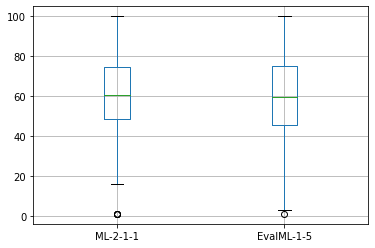

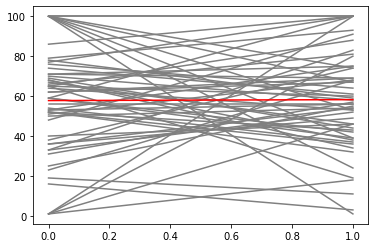

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


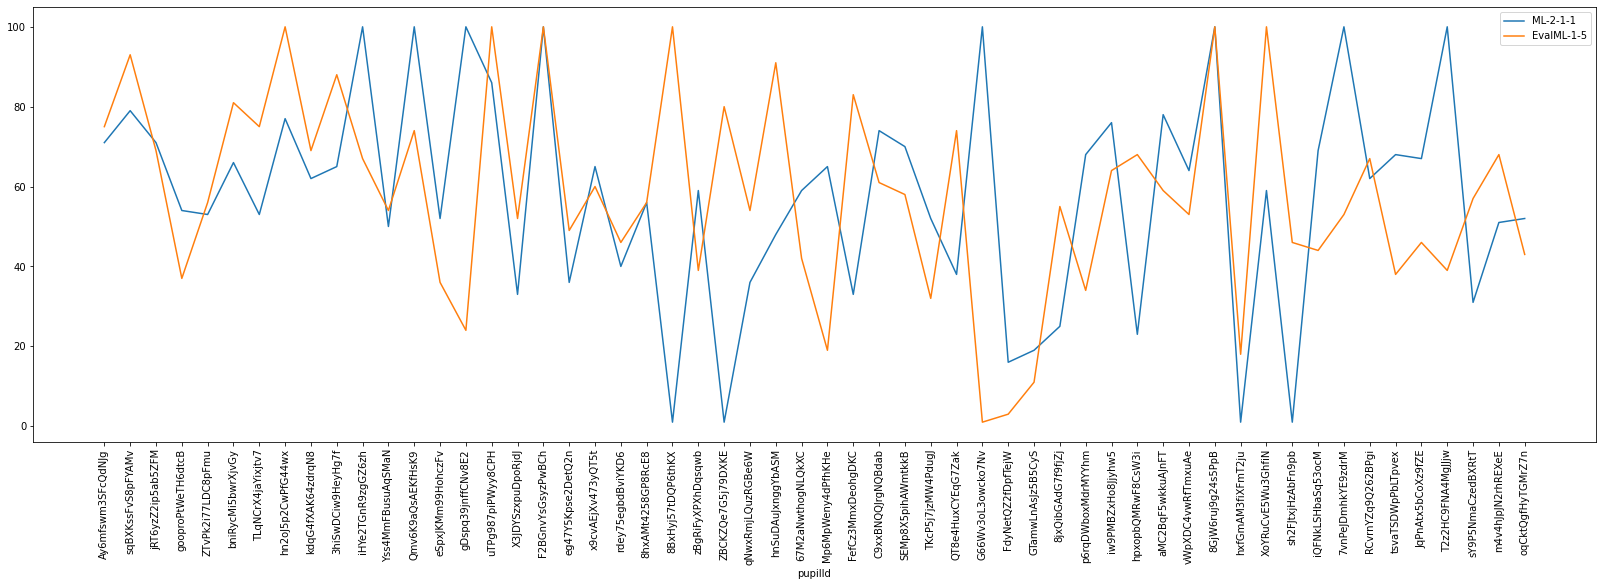

In [50]:
surveySliderStatistics(pupil_performance_df["ML-2-1-1"])
surveySliderStatistics(pupil_performance_df["EvalML-1-5"])

pupil_performance_df.boxplot(column=['ML-2-1-1', 'EvalML-1-5'])
plt.show()

plot_improvements(pupil_performance_df[['ML-2-1-1', 'EvalML-1-5']])

In [56]:
differences_0_1 = calculateDifferences(pupil_performance_df[["EvalML-1-5", "ML-2-1-1"]])

print("ShapirotestResult", stats.shapiro(differences_0_1))
# TODO: hier beide Test verwenden?
print(stats.wilcoxon(differences_0_1))
print(stats.ttest_rel(pupil_performance_df.dropna(subset=["EvalML-1-5", "ML-2-1-1"])["ML-2-1-1"], pupil_performance_df.dropna(subset=["EvalML-1-5", "ML-2-1-1"])["EvalML-1-5"]))

ShapirotestResult ShapiroResult(statistic=0.9749335646629333, pvalue=0.29257649183273315)
WilcoxonResult(statistic=700.5, pvalue=0.89434543821884)
Ttest_relResult(statistic=-0.10173317312577801, pvalue=0.9193384577871859)


* Shapiro: p 0.29 --> p-value is greater than 0.05 --> then the null hypothesis is not rejected --> normalverteilt
* Keine signifikanz, weder nach wilcoxon oder Ttest_rel --> Paket hat keinen Effekt auf die Selbsteinschätzung der SuS

### 3.2 Freitexte - Was ist ML
* 'ML-2-1-1' - Weißt du vielleicht schon etwas über das maschinelle Lernen?
* 'EvalML-1-7' - Was ist ML in eigenen Worten

#### 3.2.1 nach teacher ratings

In [59]:
differences_content = calculateDifferences(pupil_performance_df[["EvalML-1-7_rating_content", "ML-2-1-2_rating_content"]])

print(stats.shapiro(differences_content))
print(stats.wilcoxon(differences_content))

ShapiroResult(statistic=0.9216520190238953, pvalue=0.012465259060263634)
WilcoxonResult(statistic=80.0, pvalue=0.21287092067068514)


* zu hoher p-Wert (0.27) --> keine beweise dafür, dass das Paket einen Effekt auf die content ratings hatten

#### 3.2.2.1 Was ist ML - Freitext - unknown und nullanswers

In [5]:
print("-----Anzahl Abgaben-----")
print("T0: ", len(pupil_performance_df_rated['ML-2-1-2_null_answer'].dropna()))
print("T1: ", len(pupil_performance_df_rated['EvalML-1-7_null_answer'].dropna()))
print("-----'Anzahl Ich weiß es nicht-Abgaben'-----")
print("T0: ", len(pupil_performance_df_rated[pupil_performance_df_rated['ML-2-1-2_unknown']==True]))
print("T1: ", len(pupil_performance_df_rated[pupil_performance_df_rated['EvalML-1-7_unknown']==True]))
print("-----Anzahl Leerabgaben und Plagiate-----")
print("T0: ", len(pupil_performance_df_rated[pupil_performance_df_rated['ML-2-1-2_null_answer']==True]))
print("T1: ", len(pupil_performance_df_rated[pupil_performance_df_rated['EvalML-1-7_null_answer']==True]))

proportionT0unknown = round((pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[True].values[0]))*100,2)
proportionT1unknown = round((pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[True].values[0]))*100,2)
proportionT0null = round((pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[True].values[0]))*100,2)
proportionT1null = round((pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[True].values[0]))*100,2)

print("\n-----Prozentuale Veränderung-----")
print("Proportion Unknown: ", proportionT0unknown, "-->", proportionT1unknown)
print("Proportion Nullanswers: ", proportionT0null, "-->", proportionT1null, "\n")


-----Anzahl Abgaben-----
T0:  84
T1:  72
-----'Anzahl Ich weiß es nicht-Abgaben'-----
T0:  29
T1:  7
-----Anzahl Leerabgaben und Plagiate-----
T0:  11
T1:  9

-----Prozentuale Veränderung-----
Proportion Unknown:  34.52 --> 9.72
Proportion Nullanswers:  13.1 --> 12.5 



In [10]:
# immer noch viele, die sagen, sie wüssten es nicht zum Zeitpunkt T1
# --> aus welchen klassen kommen die?
pupil_performance_df_rated[pupil_performance_df_rated['EvalML-1-7_unknown']==True][["classId"]].value_counts()#

classId          
GkQSJvPTRWsLnpyR9    2
Fj6vLBZ78KswTxcPt    2
3dLAJPXXug3EMqbc5    2
SwfuMxSGoy4aKziD8    1
dtype: int64

In [18]:
# haben in diesen klassen andere etwas anderes gesagt?

"""
results:
2-3 --> 2 von 5
2-9 --> 2 von 11
2-13 --> 2 von 15
1-10 --> 1 von 11
"""

pupil_performance_df_rated[pupil_performance_df_rated['classId']=="SwfuMxSGoy4aKziD8"][["EvalML-1-7_unknown"]].value_counts()
#pupil_performance_df_rated.where(pupil_performance_df_rated['classId'] in ["GkQSJvPTRWsLnpyR9","Fj6vLBZ78KswTxcPt"])


EvalML-1-7_unknown
False                 10
True                   1
dtype: int64

In [41]:
#Signifikante Veränderung des Anteils, die nichts wissen?
print("-----Signifikanz-----")
countUn = np.array([pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[True].values[0], pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[True].values[0]])
nobsUn = np.array([(pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[True].values[0]), (pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[True].values[0])])
statUn, pvalUn = proportions_ztest(countUn, nobsUn)
print("Unknown --> stat: ", statUn, " pval", pvalUn)

countNu= np.array([pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[True].values[0], pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[True].values[0]])
nobsNu = np.array([(pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[True].values[0]), (pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[True].values[0])])
statNu, pvalNu = proportions_ztest(countNu, nobsNu)
print("Nullanswers --> stat: ", statNu, " pval", pvalNu)

-----Signifikanz-----
Unknown --> stat:  3.665268492442692  pval 0.0002470792320212062
Nullanswers --> stat:  0.11085989340779011  pval 0.9117274499246601


* two-proportion t-test für anteil unknown: p-value = 0.000247 --> Signifikanz --> Paket hat einen Effekt auf anzahl unknown-answers
* two-proportion t-test für anteil nullanswers: p-value = 0.911 --> keine signifikanz bei nullanswers. Paket hat keinen einfluss auf anzahl an leuten, die leer abgeben oder plagiieren


##### 3.2.2.1 Was ist ML - Freitext - Analyse nach eigenen Kategorien - Richtige Antworten

#### Was ist ML? - Freitexte - deskriptiv

In [136]:
#["ML-2-1-2_correct_points", 'ML-2-1-2_incorrect_points', 'ML-2-1-2_irrelevant_points', "EvalML-1-7_correct_points", "EvalML-1-7_incorrect_points", "EvalML-1-7_irrelevant_points"]
print("-----correct points-----")
surveySliderStatistics(pupil_performance_df_rated["ML-2-1-2_correct_points"])
surveySliderStatistics(pupil_performance_df_rated["EvalML-1-7_correct_points"])

print("\n-----incorrect points-----")
surveySliderStatistics(pupil_performance_df_rated["ML-2-1-2_incorrect_points"])
surveySliderStatistics(pupil_performance_df_rated["EvalML-1-7_incorrect_points"])

print("\n-----irrelevant points-----")
surveySliderStatistics(pupil_performance_df_rated["ML-2-1-2_irrelevant_points"])
surveySliderStatistics(pupil_performance_df_rated["EvalML-1-7_irrelevant_points"])

-----correct points-----
ML-2-1-2_correct_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.6301369863013698
std: 0.91
min: 0.0 und max: 3.0

EvalML-1-7_correct_points
Q1: 0.0 and Q3: 2.0
median: 1.0
mean: 1.109375
std: 1.25
min: 0.0 und max: 6.0


-----incorrect points-----
ML-2-1-2_incorrect_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.4666666666666667
std: 0.5
min: 0.0 und max: 1.0

EvalML-1-7_incorrect_points
Q1: 0.0 and Q3: 0.0
median: 0.0
mean: 0.22807017543859648
std: 0.42
min: 0.0 und max: 1.0


-----irrelevant points-----
ML-2-1-2_irrelevant_points
Q1: 0.0 and Q3: 0.0
median: 0.0
mean: 0.1111111111111111
std: 0.32
min: 0.0 und max: 1.0

EvalML-1-7_irrelevant_points
Q1: 0.0 and Q3: 0.0
median: 0.0
mean: 0.08771929824561403
std: 0.29
min: 0.0 und max: 1.0



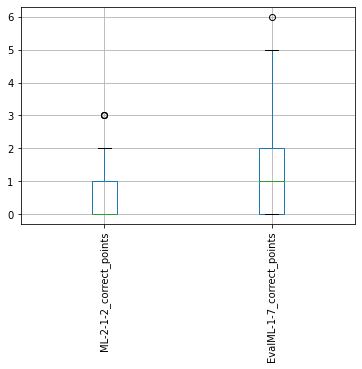

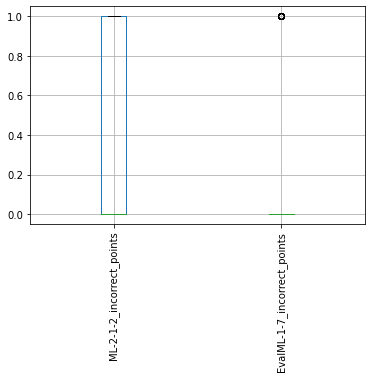

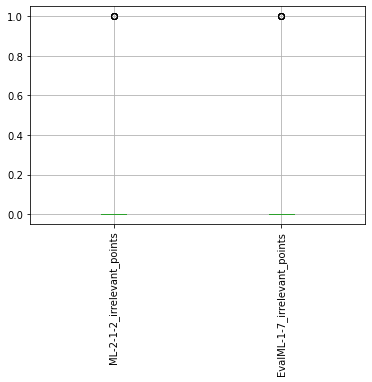

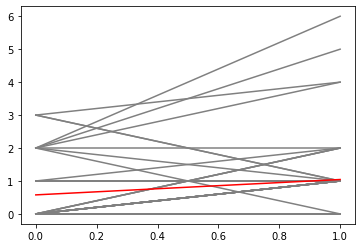

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


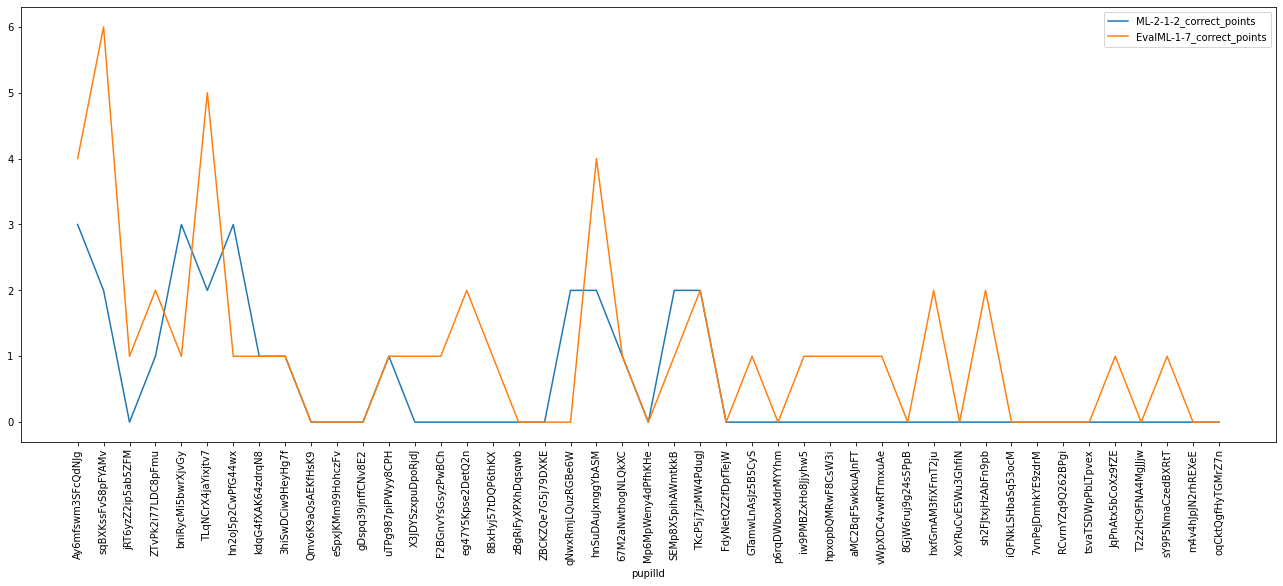

In [137]:
#["ML-2-1-2_correct_points", 'ML-2-1-2_incorrect_points', 'ML-2-1-2_irrelevant_points', "EvalML-1-7_correct_points", "EvalML-1-7_incorrect_points", "EvalML-1-7_irrelevant_points"]
pupil_performance_df_rated.boxplot(column=["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"])
plt.xticks(rotation = 90)
plt.show()

pupil_performance_df_rated.boxplot(column=['ML-2-1-2_incorrect_points', "EvalML-1-7_incorrect_points"])
plt.xticks(rotation = 90)
plt.show()

pupil_performance_df_rated.boxplot(column=['ML-2-1-2_irrelevant_points', "EvalML-1-7_irrelevant_points"])
plt.xticks(rotation = 90)
plt.show()

#pupil_performance_df_rated.boxplot(column=["ML-2-1-2_correct_points", 'ML-2-1-2_incorrect_points', 'ML-2-1-2_irrelevant_points', "EvalML-1-7_correct_points", "EvalML-1-7_incorrect_points", "EvalML-1-7_irrelevant_points"])
#plt.xticks(rotation = 90)
#plt.show()

plot_improvements(pupil_performance_df_rated[["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"]])
#plot_improvements(pupil_performance_df_rated[["AI-1-v2-1-2_incorrect_points", "AI-4-v2-1-3_incorrect_points"]])
#plot_improvements(pupil_performance_df_rated[["AI-1-v2-1-2_irrelevant_points", "AI-4-v2-1-3_irrelevant_points"]])
#zu wenige inkorrekte und irrelevante, damit die grafik gut aussieht

##### Signifikanz

In [147]:
MLdifferences_correct = calculateDifferences(pupil_performance_df_rated[["EvalML-1-7_correct_points", "ML-2-1-2_correct_points"]])
MLdifferences_incorrect = calculateDifferences(pupil_performance_df_rated[["EvalML-1-7_incorrect_points", "ML-2-1-2_incorrect_points"]])
MLdifferences_irrelevant = calculateDifferences(pupil_performance_df_rated[["EvalML-1-7_irrelevant_points", "ML-2-1-2_irrelevant_points"]])

print("\n-----Normalverteilung?-----")
print(stats.shapiro(MLdifferences_correct))
print(stats.shapiro(MLdifferences_incorrect))
print(stats.shapiro(MLdifferences_irrelevant))

print("\n-----Signifikanz-----")
print(stats.wilcoxon(MLdifferences_correct))
print(stats.wilcoxon(MLdifferences_incorrect))
print(stats.wilcoxon(MLdifferences_irrelevant))
print("sample size too small for wilcoxon on irrelevant points")

print("\n-----Effektstärke-----")
print(cohen_d(pupil_performance_df_rated.dropna(subset=["EvalML-1-7_correct_points", "ML-2-1-2_correct_points"])["EvalML-1-7_correct_points"], pupil_performance_df_rated.dropna(subset=["EvalML-1-7_correct_points", "ML-2-1-2_correct_points"])["ML-2-1-2_correct_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["EvalML-1-7_incorrect_points", "ML-2-1-2_incorrect_points"])["EvalML-1-7_incorrect_points"], pupil_performance_df_rated.dropna(subset=["EvalML-1-7_incorrect_points", "ML-2-1-2_incorrect_points"])["AI-4-v2-1-3_incorrect_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["EvalML-1-7_irrelevant_points", "ML-2-1-2_irrelevant_points"])["EvalML-1-7_irrelevant_points"], pupil_performance_df_rated.dropna(subset=["EvalML-1-7_irrelevant_points", "ML-2-1-2_irrelevant_points"])["ML-2-1-2_irrelevant_points"]))


-----Normalverteilung?-----
ShapiroResult(statistic=0.863905131816864, pvalue=8.516922389389947e-05)
ShapiroResult(statistic=0.6908186674118042, pvalue=1.0665431545930915e-05)
ShapiroResult(statistic=0.5052640438079834, pvalue=9.6266269622447e-08)

-----Signifikanz-----
WilcoxonResult(statistic=61.5, pvalue=0.016453801586694634)
WilcoxonResult(statistic=7.0, pvalue=0.4142161782425253)
WilcoxonResult(statistic=2.0, pvalue=0.5637028616507731)
sample size too small for wilcoxon on irrelevant points

-----Effektstärke-----
0.39490425053246486
0.9095394684417764
0.17289101870203108


/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


* signifikante verbesserung bei den korrekten aussagen
  * effektstärke 0.39: leichter bis mittlerer effekt
* keine signifikanz bei incorrecten oder irrelevanten

#### Unterschiede zwischen Klassen

In [53]:
pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"]].agg(np.mean).dropna()


,ML-2-1-2_correct_points,EvalML-1-7_correct_points
classId,,
3dLAJPXXug3EMqbc5,0.000000,0.666667
Fj6vLBZ78KswTxcPt,0.875000,1.142857
GkQSJvPTRWsLnpyR9,0.000000,0.200000
NCm8NNbAmNsur5S33,0.230769,1.090909
SwfuMxSGoy4aKziD8,0.000000,0.900000
qFEyvypMn4sAwLwtc,1.473684,2.444444


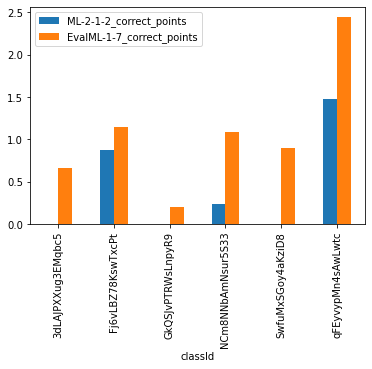

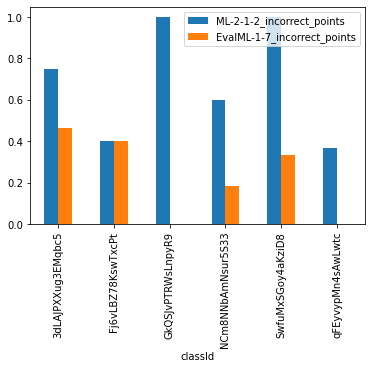

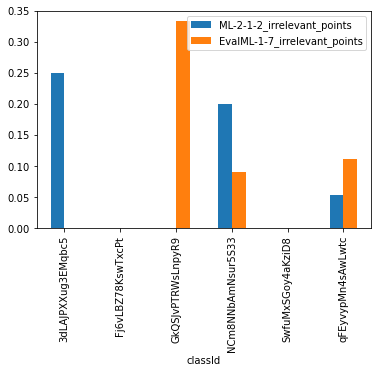

In [148]:
pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"]].agg(np.mean).dropna().plot(y=["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"], kind="bar")
plt.show()
pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_incorrect_points", "EvalML-1-7_incorrect_points"]].agg(np.mean).dropna().plot(y=["ML-2-1-2_incorrect_points", "EvalML-1-7_incorrect_points"], kind="bar")
plt.show()
pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_irrelevant_points", "EvalML-1-7_irrelevant_points"]].agg(np.mean).dropna().plot(y=["ML-2-1-2_irrelevant_points", "EvalML-1-7_irrelevant_points"], kind="bar")
plt.show()
# manche Klassen haben wert null --> sieht man im barplot nicht gut

* manche Klassen haben wert null --> sieht man im barplot nicht gut
* eine klasse (qFEyvyMn4sAwLwtc) scheint schon relativ viel vorwissen zu haben. Trotzdem hat sie klar lernzuwachs

### 3.3 - Was ist ML - MC

In [101]:
analyse_mc(['EvalML-1-8'], 8)

EvalML-1-8
Welche der Aussagen über maschinelles Lernen stimmen?
*Algorithmen des maschinellen Lernens können aus vorhandenen Daten selbständig lernen - True
*Beim überwachten Lernen nutzen wir Daten ohne Label - False
*Beim unüberwachten Lernen versuchen wir, Strukturen in den Daten zu entdecken - True
*Clustering ist ein Beispiel für unüberwachtes Lernen - True
*Wenn wir für Daten Label vorhersagen wollen, betreiben wir Clustering - False
*Wenn wir für Daten Label vorhersagen wollen, betreiben wir überwachtes Lernen - True
*Algorithmen des maschinellen Lernens lernen nur, was in den Daten vorhanden ist. Daher ist die Auswahl an Trainingsdaten sehr wichtig - True
*Algorithmen des maschinellen Lernens benötigen oft große Mengen an Daten, damit sie gute Ergebnisse erzielen - True
[True, False, True, True, False, True, True, True]


Average number of errors: 2.7916666666666665
Expected number of errors with guessing:  4.0


## 4. unterschied überwachtes und unüberwachtes?
### 4.1 überwacht vs unüberwacht - Selbsteinschätzung
<b>Es gibt keinen T0, nur einen T1!</b>
* 'EvalML-1-6' Wie sehr hast du das Gefühl, verstanden zu haben, was der Unterschied zwischen überwachtem und unüberwachtem Lernen ist?

In [11]:
print(len(pupil_performance_df["EvalML-1-6"].dropna()))

72


EvalML-1-6
Q1: 43.75 and Q3: 76.5
median: 54.5
mean: 58.736111111111114
std: 25.67
min: 1.0 und max: 100.0



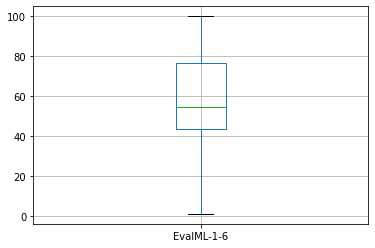

In [56]:
surveySliderStatistics(pupil_performance_df["EvalML-1-6"])

pupil_performance_df.boxplot(column=["EvalML-1-6"])
plt.show()

### 4.2 überwacht vs unüberwacht - MC Definitionen
* MC: 'Classification-1-1-1', 'Was war unüberwachtes Lernen noch gleich?'
* MC: "Clustering-1-1-1" 'Was war unüberwachtes Lernen noch gleich?'

In [103]:
analyse_mc(['Classification-1-1-1'], 3)

Classification-1-1-1
Welche Aussagen stimmen?
*Beim überwachten Lernen braucht man Daten ohne Label - False
*Einen Algorithmus zu trainieren, der Bildern mit Hunden das Label “Hund” gibt, wäre ein Fall für überwachtes Lernen - True
*Beim überwachten Lernen versucht man Struktur in Daten zu finden - False
[False, True, False]


Average number of errors: 1.0105263157894737
Expected number of errors with guessing:  1.5


In [105]:
analyse_mc(["Clustering-1-1-1"], 4)

Clustering-1-1-1
Was war unüberwachtes Lernen noch gleich?
*Beim unüberwachten Lernen nutzt man Daten mit Label - False
*Beim unüberwachten Lernen wollen wir die richtigen Label für neue Daten vorhersagen - False
*Beim unüberwachten Lernen hat man keine Label für die Daten - True
*Beim unüberwachten Lernen geht es darum, Struktur in den Daten zu finden - True
[False, False, True, True]


Average number of errors: 1.3571428571428572
Expected number of errors with guessing:  2.0


### 4.3 überwacht vs unüberwacht - MC transfer

In [106]:
print_mc(['ML-3-1-2', 'ML-3-1-3', 'ML-3-1-4'])
mc_analysis(['ML-3-1-2', 'ML-3-1-3', 'ML-3-1-4'])

ML-3-1-2
Ein Empfehlungssystem für Musik, das lernt, was du für Musik magst und dann für neu erscheinende Musik voraussagt, ob du sie mögen würdest.
*Überwachtes Lernen - True
*Unüberwachtes Lernen - False
[True, False]

ML-3-1-3
Die Gesichtserkennung von deinem Handy. Anfangs musst du dein Gesicht aus verschiedenen Winkeln filmen. Anhand dieser Beispiele lernt es, dein Gesicht zu erkennen. Wenn dann irgendein Gesicht versucht, dein Handy zu entsperren, kann es voraussagen, ob es dein Gesicht ist oder nicht.
*Überwachtes Lernen - True
*Unüberwachtes Lernen - False
[True, False]

ML-3-1-4
Wenn wir Youtuber nach der Anzahl ihrer Follower und der Themen ihrer Videos gruppieren.
*Überwachtes Lernen - False
*Unüberwachtes Lernen - True
[False, True]


Average number of errors: 2.5060240963855422


In [107]:
analyse_mc(['Classification-2-1-8'], 3)

Classification-2-1-8
Welche Aussagen stimmen?
*Ein Algorithmus, der dir basierend auf deinen Lieblingsfächern einen Beruf vorschlägt, könnte man mittels überwachtem Lernen umsetzen - True
*Ein Algorithmus, der ähnliche Berufe gruppiert, gehört zum überwachten Lernen - False
*Ein Algorithmus, der anhand vieler alter Fälle gelernt hat, medizinische Diagnosen zu stellen, gehört zum überwachten Lernen - True
[True, False, True]


Average number of errors: 1.2222222222222223
Expected number of errors with guessing:  1.5


In [108]:
analyse_mc(["EvalML-1-9"], 2)

EvalML-1-9
Welche Art des Lernens sind folgende Aufgaben?
*Eine Webseite, die für neue Rezepte vorhersagt, ob sie dir “gefallen” oder “nicht gefallen”, ist eine Aufgabe für das überwachte Lernen - True
*Eine Webseite, die ähnliche Rezepte gruppiert, wäre eine Aufgabe für das Clustering - True
[True, True]


Average number of errors: 0.6527777777777778
Expected number of errors with guessing:  1.0


## 5. Grenzen ML / Traininsdaten
### 5.1 Grenzen ML / Traininsdaten - Freitext
betrachten:
* LimitsML-1-2_correct_points (1 wenn richtig, sonst 0)
* LimitsML-1-2_null_answer (damit nur richtige abgaben gezählt werden)

In [149]:
print(pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True)["LimitsML-1-2_correct_points"].dropna().value_counts())

number_correct_cases = pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True)["LimitsML-1-2_correct_points"].dropna().value_counts().values[0]
number_incorrect_cases = pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True)["LimitsML-1-2_correct_points"].dropna().value_counts().values[1]
percentage_correct = number_correct_cases / (number_correct_cases + number_incorrect_cases)

print("\nPercentage of correct cases: ", percentage_correct)

1.0    40
0.0    29
Name: LimitsML-1-2_correct_points, dtype: int64

Percentage of correct cases:  0.5797101449275363


#### Unterschiede zwischen den Klassen

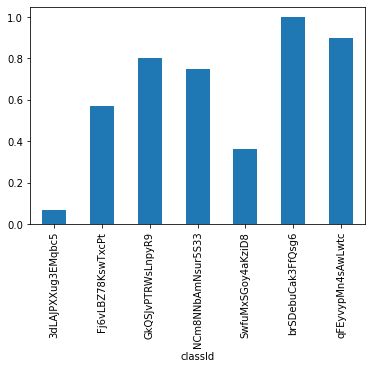

In [22]:
pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True).groupby("classId")["LimitsML-1-2_correct_points"].agg(np.mean).dropna().plot(kind="bar")
# y-titel: Anteil Korrekt
plt.show()


### 5.2 Grenzen ML / Traininsdaten - MCs

In [110]:
analyse_mc(['LimitsML-1-1'], 2)

LimitsML-1-1
Was könnte passieren, wenn wir bei den Hundebildern nur Bilder von einer Hunderasse nutzen würden?
*Der Algorithmus würde nur Hunde dieser Rasse zuverlässig als Hunde erkennen - True
*Bei Hunden anderer Rassen ist es schwer zu sagen, ob er sie erkennen würde, aber sehr wahrscheinlich nicht so zuverlässig - True
*Der Algorithmus würde immer noch alle Hunderassen als Hunde erkennen, weil es keine Katzen sind - False
[True, True, False]


Average number of errors: 0.6973684210526315
Expected number of errors with guessing:  1.0


In [111]:
analyse_mc(['Impact-1-1-1'], 2)

Impact-1-1-1
Was glaubst du, warum das Gesicht der dunkelhäutigen Frau nicht erkannt wurde?
*Der Algorithmus wurde falsch programmiert - False
*Die Trainingsdaten, mit denen der Algorithmus gelernt hat, enthielten keine oder kaum Bilder von dunkelhäutigen Menschen - True
[False, True]


Average number of errors: 0.21818181818181817
Expected number of errors with guessing:  1.0


# Itemanalyse

## Inputfields

#### Itemschwierigkeit Inputfields

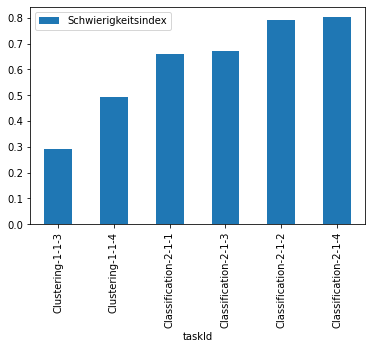

                      Schwierigkeitsindex
taskId                                   
Clustering-1-1-3                 0.292929
Clustering-1-1-4                 0.494949
Classification-2-1-1             0.659341
Classification-2-1-3             0.670330
Classification-2-1-2             0.791209
Classification-2-1-4             0.802198


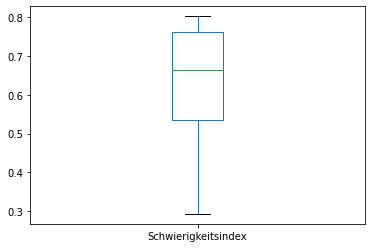

In [15]:
schwierigkeitsDict = {"taskId": [], "Schwierigkeitsindex": []}

for taskId in inputfields["taskId"].unique():
    task_i = inputfields[inputfields["taskId"] == taskId]
    
    with_false_attempts = task_i[task_i["falseAttempts"] == task_i["falseAttempts"]]
    without_false_attempts = task_i[task_i["falseAttempts"] != task_i["falseAttempts"]]

    itemSchwierigkeit = len(without_false_attempts) / (len(without_false_attempts)+len(with_false_attempts))
    schwierigkeitsDict["taskId"].append(taskId)
    schwierigkeitsDict["Schwierigkeitsindex"].append(itemSchwierigkeit)

itemSchwierigkeitsDf = pd.DataFrame(schwierigkeitsDict).set_index('taskId')
itemSchwierigkeitsDf.sort_values(by=['Schwierigkeitsindex'], inplace=True)

itemSchwierigkeitsDf.plot(kind="bar")
plt.show()

print(itemSchwierigkeitsDf)

itemSchwierigkeitsDf.plot(kind="box")
plt.show()

Besonders schwere Inputfields:
* Clustering-1-1-3                 0.292929
* Clustering-1-1-4                 0.494949

Sonst wurden alle von 66-80% der SuS gelöst. Keine der Aufgaben ist ein Ausreißer nach Schwierigkeitsindex.

##### Machen immer die gleichen SuS Fehler?

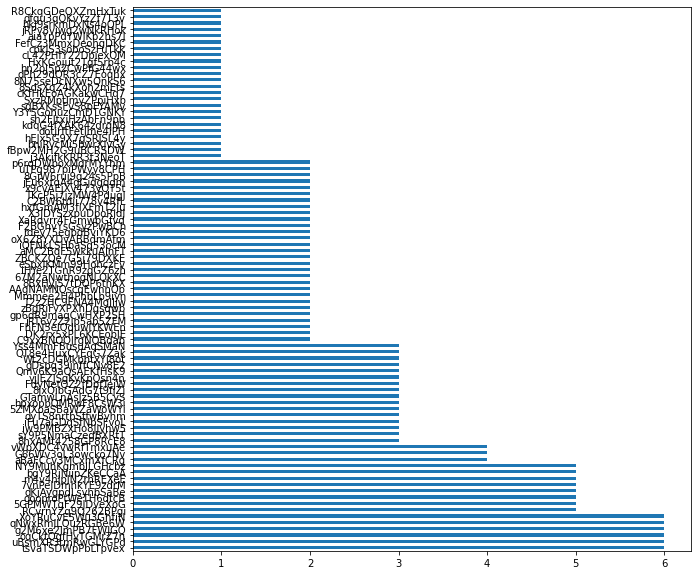

In [12]:
if_false_attempt_df = inputfields.dropna(subset=['falseAttempts'])

if_false_attempt_df["pupilId"].value_counts().plot(kind='barh', figsize=(10,10))
plt.show()

## MC

#### Itemschwierigkeit

schwierigkeitsindex = Zahl der „Richtiglöser“ / Zahl der Probanden

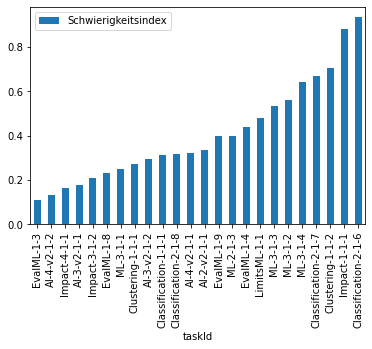

                      Schwierigkeitsindex
taskId                                   
EvalML-1-3                       0.109589
AI-4-v2-1-2                      0.133929
Impact-4-1-1                     0.163265
AI-3-v2-1-1                      0.176000
Impact-3-1-2                     0.207921
EvalML-1-8                       0.232877
ML-3-1-1                         0.250000
Clustering-1-1-1                 0.272727
AI-3-v2-1-2                      0.296000
Classification-1-1-1             0.312500
Classification-2-1-8             0.318681
AI-4-v2-1-1                      0.321429
AI-2-v2-1-1                      0.333333
EvalML-1-9                       0.397260
ML-2-1-3                         0.400000
EvalML-1-4                       0.438356
LimitsML-1-1                     0.480519
ML-3-1-3                         0.535714
ML-3-1-2                         0.559524
ML-3-1-4                         0.642857
Classification-2-1-7             0.670330
Clustering-1-1-2                 0

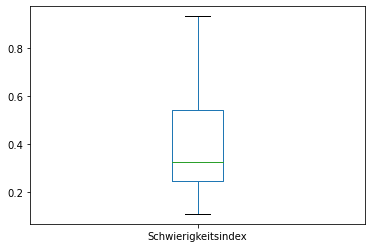

In [55]:
schwierigkeitsDict = {"taskId": [], "Schwierigkeitsindex": []}
#schwierigkeitsDict1 = {}

for taskId in multipleChoice["taskId"].unique():
    #print(taskId)
    task_i = multipleChoice[multipleChoice["taskId"] == taskId]
    
    with_false_attempts = task_i[task_i["falseAttempts"] == task_i["falseAttempts"]]
    without_false_attempts = task_i[task_i["falseAttempts"] != task_i["falseAttempts"]]
    #print(len(with_false_attempts))
    #print(len(without_false_attempts))

    itemSchwierigkeit = len(without_false_attempts) / (len(without_false_attempts)+len(with_false_attempts))
    #print(itemSchwierigkeit)
    #print("------------")
    schwierigkeitsDict["taskId"].append(taskId)
    schwierigkeitsDict["Schwierigkeitsindex"].append(itemSchwierigkeit)
    #schwierigkeitsDict1.append({taskId: itemSchwierigkeit})

itemSchwierigkeitsDf = pd.DataFrame(schwierigkeitsDict).set_index('taskId')
itemSchwierigkeitsDf.sort_values(by=['Schwierigkeitsindex'], inplace=True)

itemSchwierigkeitsDf.plot(kind="bar")
plt.show()

print(itemSchwierigkeitsDf)

itemSchwierigkeitsDf.plot(kind="box")
plt.show()

Es gibt keine formalen Ausreißer bei der Itemschwierigkeit, Trotzdem gibt es eine große Variabilität.

Ein niedriger Index heißt, besonders wenige SuS konnten die Aufgabe direkt lösen.

besonders schwere (unter 0.2):
* EvalML-1-3                 0.109589
* AI-4-v2-1-2                0.133929
* Impact-4-1-1               0.163265
* AI-3-v2-1-1                0.176000

besonders leichte (vllt auch nur die beiden über 0.8):
* Clustering-1-1-2           0.707071
* Impact-1-1-1               0.882883
* Classification-2-1-6       0.934066

#### Welche Aufgaben mussten besonders oft wiederholt werden? (falseAttempts mehr als 2*hints +1)

<AxesSubplot:ylabel='taskId'>

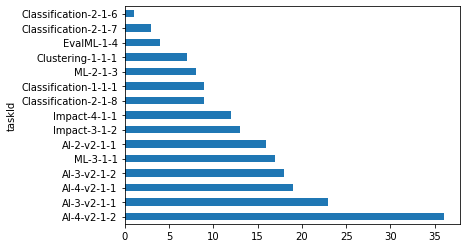

In [44]:
multipleChoice[multipleChoice["numberFalseAttempts"] >2*multipleChoice["numberHints"]+1].value_counts("taskId").plot(kind="barh")

#### Welche Antworten sind die schwierigsten?

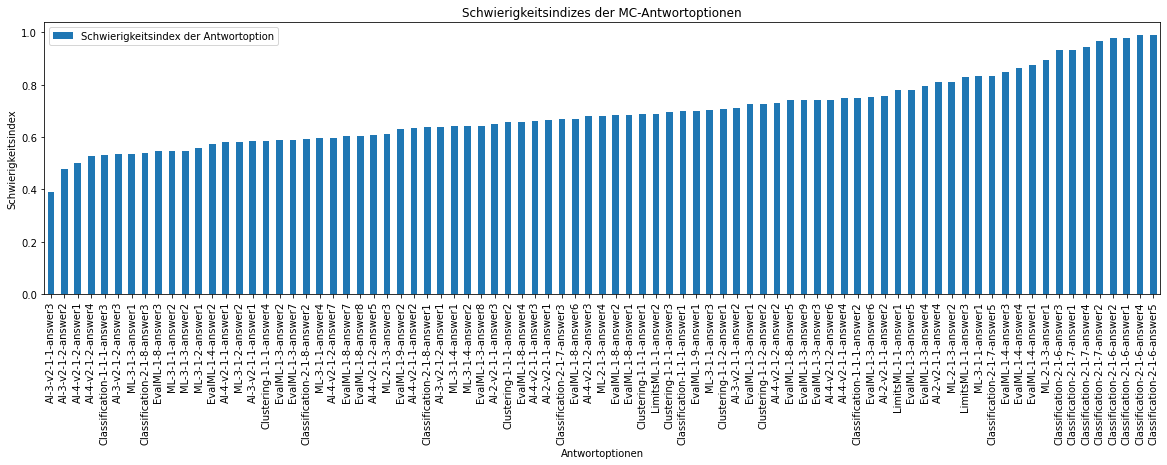

,Schwierigkeitsindex der Antwortoption
Antwortoptionen,
AI-3-v2-1-1-answer3,0.392
AI-3-v2-1-2-answer2,0.480
AI-4-v2-1-2-answer1,0.500
AI-4-v2-1-2-answer4,0.527
Classification-1-1-1-answer3,0.531
...,...
Classification-2-1-7-answer2,0.967
Classification-2-1-6-answer2,0.978
Classification-2-1-6-answer1,0.978


In [8]:
MA_mcs_taskIds = ["AI-2-v2-1-1", "AI-3-v2-1-1", "AI-3-v2-1-2", "AI-4-v2-1-1", "AI-4-v2-1-2", "ML-2-1-3", "ML-3-1-1", "ML-3-1-2", "ML-3-1-3", "ML-3-1-4", "Clustering-1-1-1", "Clustering-1-1-2", "Classification-1-1-1", "Classification-2-1-6", "Classification-2-1-7", "Classification-2-1-8", "LimitsML-1-1", "EvalML-1-3", "EvalML-1-4", "EvalML-1-8", "EvalML-1-9"]

answersByDifficulty = {"Antwortoptionen": [], "Schwierigkeitsindex der Antwortoption": []}

for taskId in MA_mcs_taskIds:
    task_i = multipleChoice[multipleChoice["taskId"] == taskId]
    sampleSolution_i = list(task_i["sampleSolution"][0:1])[0]
    
    with_false_attempts = task_i[task_i["falseAttempts"] == task_i["falseAttempts"]]
    first_falseAttempts_i = [elem[0] for elem in with_false_attempts["falseAttempts"]]
    nr_errors_in_first_false_attempt = np.array([0 for answer in sampleSolution_i])
    for falseAttempt in first_falseAttempts_i:
        nr_errors_in_first_false_attempt += np.array([a != f for a,f in zip(sampleSolution_i,falseAttempt)]).astype(int)
    
    for index, entry in pd.DataFrame(nr_errors_in_first_false_attempt).iterrows():
        answersByDifficulty["Antwortoptionen"].append(taskId+"-answer"+str(index+1))
        answersByDifficulty["Schwierigkeitsindex der Antwortoption"].append(round((len(task_i)-entry[0])/len(task_i),3))

answersByDifficultyDf = pd.DataFrame(answersByDifficulty).set_index('Antwortoptionen')
answersByDifficultyDf.sort_values(by=['Schwierigkeitsindex der Antwortoption'], inplace=True, ascending=True)

answersByDifficultyDf.plot(kind="bar", figsize=(20,5))
plt.title("Schwierigkeitsindizes der MC-Antwortoptionen")
plt.ylabel('Schwierigkeitsindex')
plt.savefig('plots/ItemschwierigkeitsindexTight.png', bbox_inches='tight')
plt.show()

#print(answersByDifficultyDf.to_string())
answersByDifficultyDf

In [11]:
print(len(answersByDifficultyDf))

83


##### Wie viele Antwortoptionen sind wie schwer

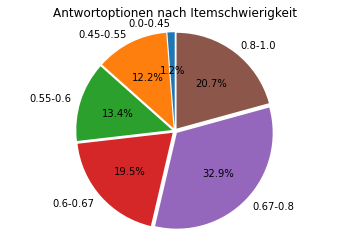

In [9]:
# Data to plot
cuts = [0, 0.45, 0.55, 0.6, 0.67, 0.8, 1.0]
numbers_in_each_bracket = []
for i in range(len(cuts)):
    if (i <= 5):
        numbers_in_each_bracket.append(len(answersByDifficultyDf[(answersByDifficultyDf["Schwierigkeitsindex der Antwortoption"]>cuts[i]) & (answersByDifficultyDf["Schwierigkeitsindex der Antwortoption"]<cuts[i+1])]))
#labels = ['Schlechter als raten', 'Ungefähr raten', 'Etwas leichter als Raten', 'Leichter als raten', "Leicht", "Sehr leicht"]
labels = ['0.0-0.45', '0.45-0.55', '0.55-0.6', '0.6-0.67', "0.67-0.8", "0.8-1.0"]

sizes = numbers_in_each_bracket
explode = (0.03, 0.03, 0.03, 0.03, 0.03, 0.03)  # explode 1st slice

# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode) #, colors=colors,
#plt.legend(['<45%', '45-55%', '55-60%', '60-67%', "67-80", ">80%"], loc=5)
#plt.legend(['0.0-0.45', '0.45-0.55', '0.55-0.6', '0.6-0.67', "0.67-0.8", "0.8-1.0"], loc=5)
plt.title("Antwortoptionen nach Itemschwierigkeit")

plt.axis('equal')
plt.show()

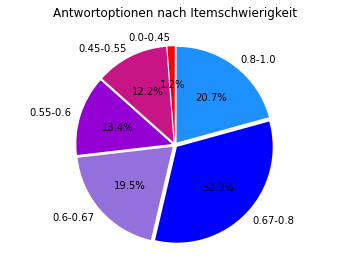

In [10]:
fig, ax1 = plt.subplots(nrows=1, ncols=1) #figsize=(9, 4)
colors=["red", "mediumvioletred", "darkviolet", "mediumpurple", "blue", "dodgerblue"]
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors) #,
#plt.legend(['<45%', '45-55%', '55-60%', '60-67%', "67-80", ">80%"], loc=5)
#plt.legend(['0.0-0.45', '0.45-0.55', '0.55-0.6', '0.6-0.67', "0.67-0.8", "0.8-1.0"], loc=5)
ax1.set_title('Antwortoptionen nach Itemschwierigkeit', pad=20)

plt.axis('equal')
plt.show()

# Desktiprives

## Anzahl Aufgaben pro SuS

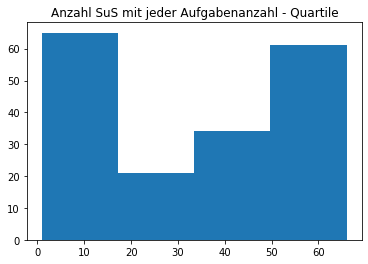

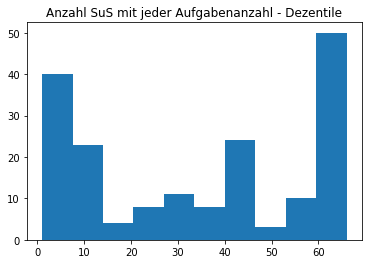

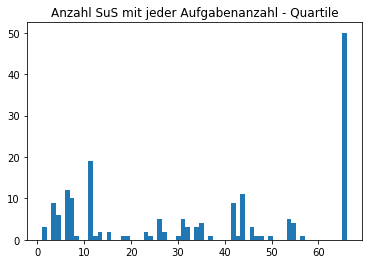

In [46]:
# anzahl tasks per pupil
plt.hist(pupil_performance_df["nr_tasks_per_pupil"], bins=4)
plt.title("Anzahl SuS mit jeder Aufgabenanzahl - Quartile")
plt.show()

plt.hist(pupil_performance_df["nr_tasks_per_pupil"], bins=10)
plt.title("Anzahl SuS mit jeder Aufgabenanzahl - Dezentile")
plt.show()

plt.hist(pupil_performance_df["nr_tasks_per_pupil"], bins=np.max(pupil_performance_df["nr_tasks_per_pupil"]))
plt.title("Anzahl SuS mit jeder Aufgabenanzahl - Quartile")
plt.show()

## Feedback zum Paket
* ('AIClosing-1-7', 'Hattest du Spaß?')
* ('AIClosing-1-8', 'Hast du etwas gelernt?')

AIClosing-1-6
Q1: 58.25 and Q3: 100.0
median: 75.0
mean: 73.82291666666667
std: 24.61
min: 1.0 und max: 100.0

-----Hattest du Spaß?-----


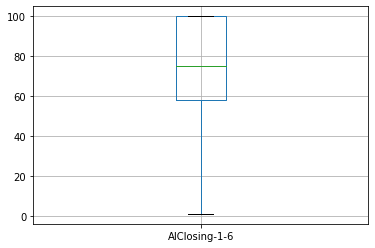

AIClosing-1-7
Q1: 62.75 and Q3: 98.25
median: 75.5
mean: 74.625
std: 24.37
min: 1.0 und max: 100.0

-----Hast du etwas gelernt?-----


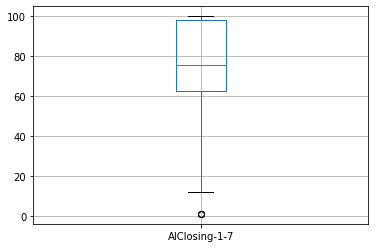

In [78]:
for taskId in ["AIClosing-1-6", "AIClosing-1-7"]:
    surveySliderStatistics(pupil_performance_df[taskId])
    if(taskId == "AIClosing-1-6"):
        print("-----Hattest du Spaß?-----")
    else:
        print("-----Hast du etwas gelernt?-----")
    pupil_performance_df.boxplot(column=[taskId])
    plt.show()

## Surveyslider

### Surveyslider Antworten

TASK   AI-1-v2-1-1: Wie gut weißt du schon, was KI ist?
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 65.5
mean: 62.11267605633803
std: 27.477032301657474


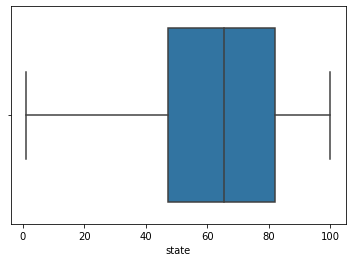

Durations:


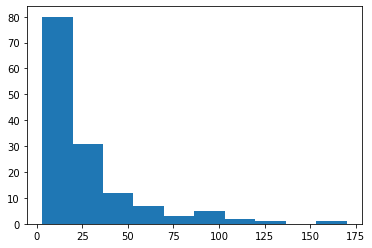

median duration: 16.0
mean duration: 26.47887323943662
-------------------------------------------------------------


TASK   AI-4-v2-1-4: Wie gut hast du jetzt verstanden, was KI ist?
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 68.0
mean: 68.91071428571429
std: 25.17777987610893


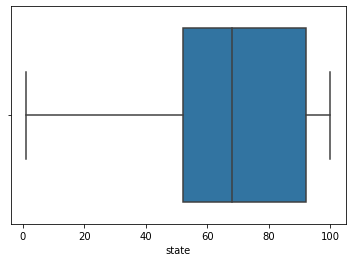

Durations:


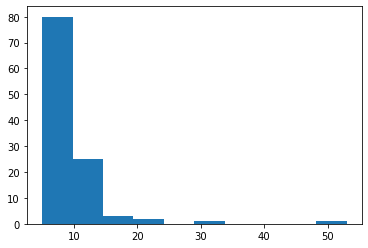

median duration: 7.5
mean duration: 9.044642857142858
-------------------------------------------------------------


TASK   AI-4-v2-1-5: Wie gut hast du den Unterschied zwischen spezifischer und allgemeiner KI verstanden?
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 61.0
mean: 61.410714285714285
std: 29.875800518691598


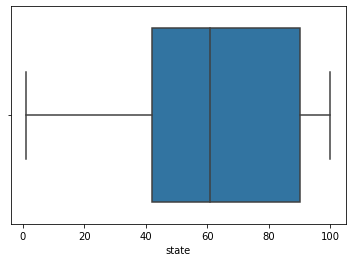

Durations:


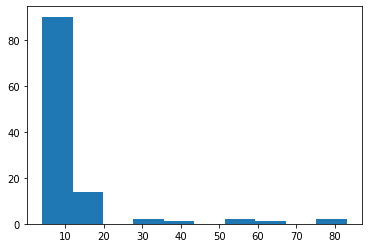

median duration: 8.0
mean duration: 11.526785714285714
-------------------------------------------------------------


TASK   ML-2-1-1: Wie gut weißt du schon, was Maschinelles Lernen ist?
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 62.0
mean: 60.34117647058824
std: 24.981194311004273


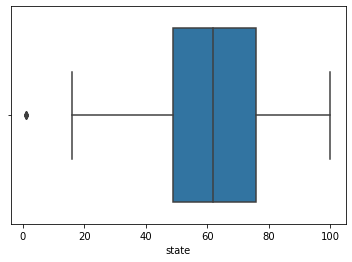

Durations:


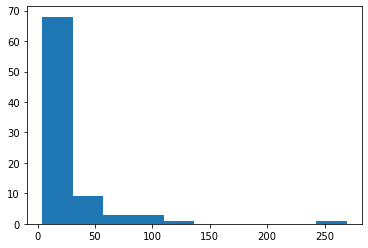

median duration: 9.0
mean duration: 22.729411764705883
-------------------------------------------------------------


TASK   EvalML-1-1: Wie gut hast du verstanden, was KI ist? Sei dabei so ehrlich es geht damit wir diese Inhalte noch verbessern können.
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 65.0
mean: 63.397260273972606
std: 25.204772175901663


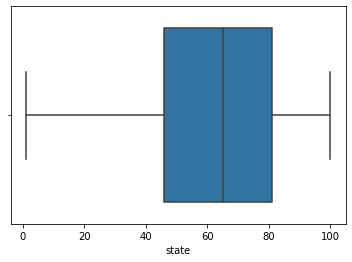

Durations:


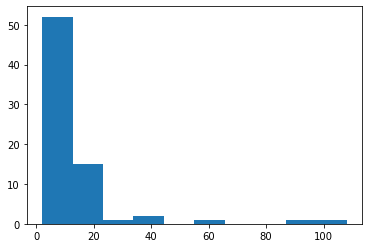

median duration: 10.0
mean duration: 14.246575342465754
-------------------------------------------------------------


TASK   EvalML-1-2: Wie gut hast du den Unterschied zwischen spezifischer und allgemeiner KI verstanden?
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 59.0
mean: 61.534246575342465
std: 27.624231070575892


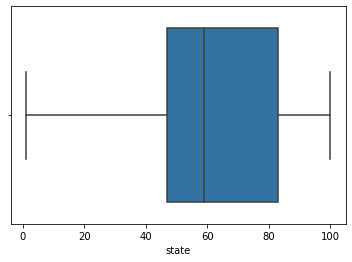

Durations:


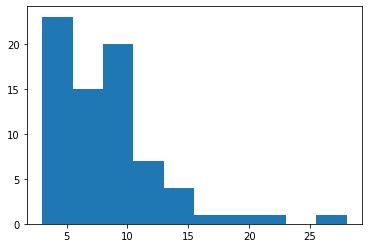

median duration: 7.0
mean duration: 8.178082191780822
-------------------------------------------------------------


TASK   EvalML-1-5: Wie gut hast du verstanden, was maschinelles Lernen ist? Sei dabei so ehrlich es geht, damit wir diese Inhalte noch verbessern können.
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 60.0
mean: 61.21917808219178
std: 24.77307783917495


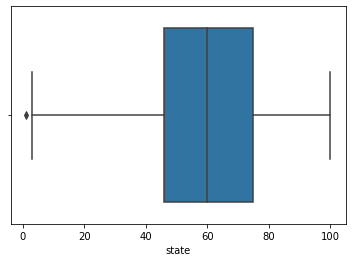

Durations:


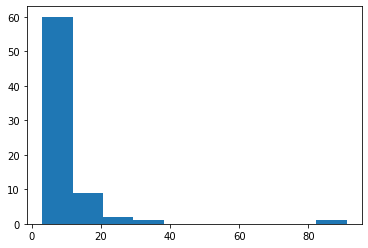

median duration: 7.0
mean duration: 9.493150684931507
-------------------------------------------------------------


TASK   EvalML-1-6: Wie sehr hast du das Gefühl, verstanden zu haben, was der Unterschied zwischen überwachtem und unüberwachtem Lernen ist?
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 55.0
mean: 59.3013698630137
std: 25.763776701102987


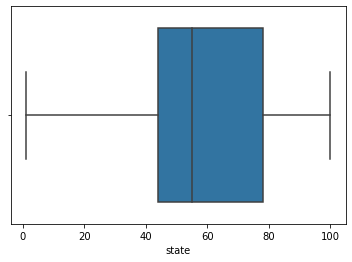

Durations:


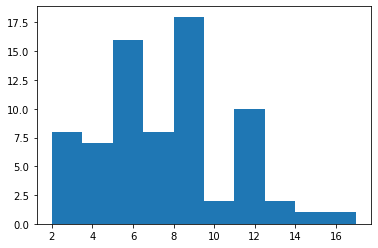

median duration: 7.0
mean duration: 7.36986301369863
-------------------------------------------------------------


TASK   Impact-2-1-2: Ich würde gerne in einem Land leben, dass den Alltag aller Bürger mit KI überwacht.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 23.5
mean: 29.74137931034483
std: 28.50563183606645


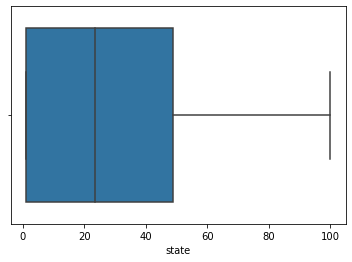

Durations:


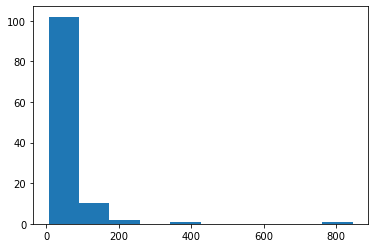

median duration: 22.0
mean duration: 48.11206896551724
-------------------------------------------------------------


TASK   Impact-2-1-3: Die Überwachung des Alltags aller Bürger sehe ich sehr kritisch.
Von Stimme nicht zu bis Stimme stark zu
min: 6
max: 100
median: 75.0
mean: 71.91379310344827
std: 24.325936550534742


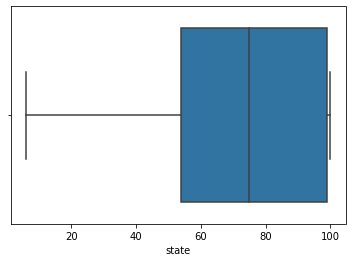

Durations:


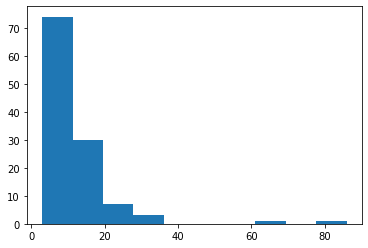

median duration: 10.0
mean duration: 12.439655172413794
-------------------------------------------------------------


TASK   Impact-2-1-4: Mich würde es stören, mittels KI-Technologien überwacht zu werden.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 79.0
mean: 73.38793103448276
std: 26.3231809312642


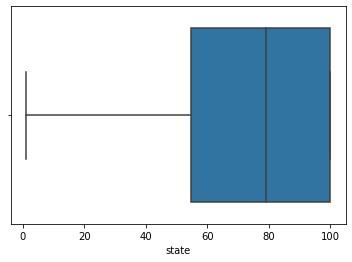

Durations:


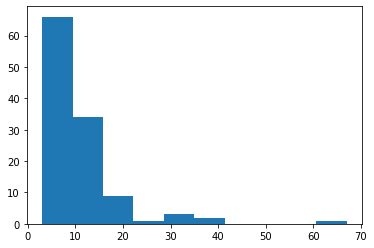

median duration: 9.0
mean duration: 11.094827586206897
-------------------------------------------------------------


TASK   Impact-2-1-5: Die Überwachung durch die Regierung bietet viele Vorteile für die Gesellschaft.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 47.0
mean: 43.98275862068966
std: 25.517736481683336


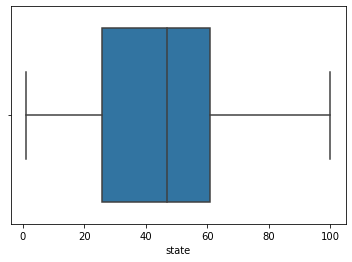

Durations:


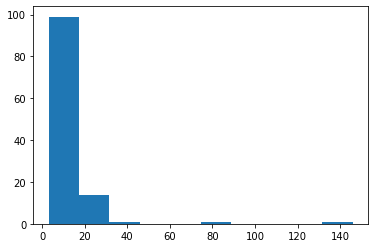

median duration: 9.0
mean duration: 12.517241379310345
-------------------------------------------------------------


TASK   Impact-2-1-6: Ich würde nicht in einem Land leben wollen, dass meinen Alltag überwacht.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 84.0
mean: 75.37931034482759
std: 27.176515969013227


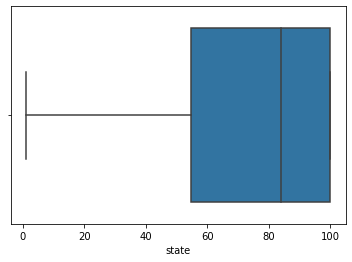

Durations:


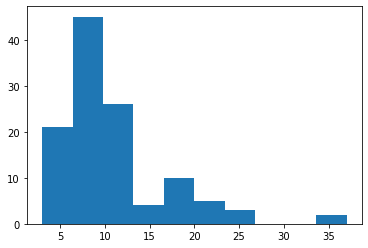

median duration: 8.5
mean duration: 10.53448275862069
-------------------------------------------------------------


TASK   Impact-2-1-7: In einem Land mit Überwachung würde ich mich sehr sicher fühlen.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 47.5
mean: 43.53448275862069
std: 25.919447842432895


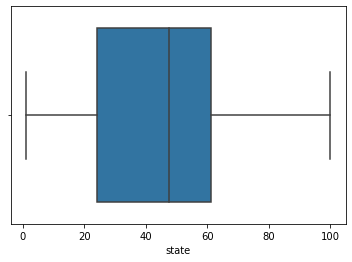

Durations:


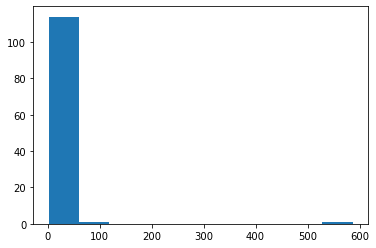

median duration: 9.0
mean duration: 15.379310344827585
-------------------------------------------------------------


TASK   AIClosing-1-1: KI wird das Leben der Menschen verbessern.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 63.0
mean: 63.02061855670103
std: 23.363986464961695


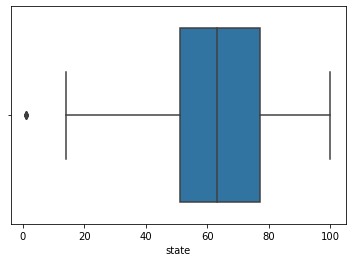

Durations:


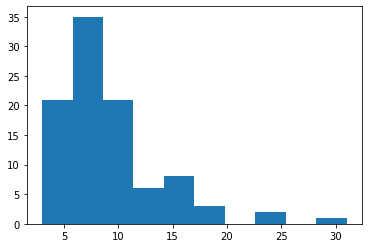

median duration: 8.0
mean duration: 8.948453608247423
-------------------------------------------------------------


TASK   AIClosing-1-2: Bei der Entwicklung von KI gibt es Risiken, die bedacht werden müssen
Von Stimme nicht zu bis Stimme stark zu
min: 19
max: 100
median: 74.0
mean: 76.63917525773196
std: 20.462782694649817


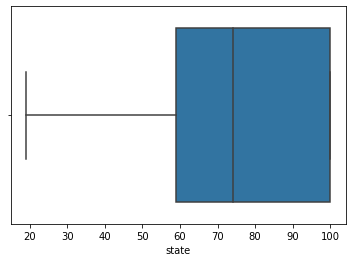

Durations:


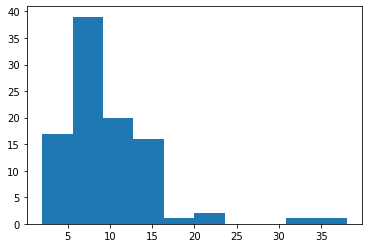

median duration: 9.0
mean duration: 9.443298969072165
-------------------------------------------------------------


TASK   AIClosing-1-3: KI birgt eine Gefahr für die Menschheit.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 48.0
mean: 50.865979381443296
std: 23.01439659962728


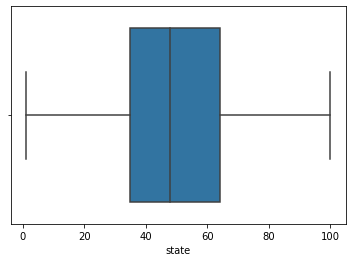

Durations:


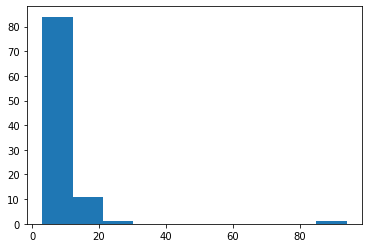

median duration: 8.0
mean duration: 9.31958762886598
-------------------------------------------------------------


TASK   AIClosing-1-4: Die Vorteile durch die Entwicklung von KI überwiegen die Risiken.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 53.0
mean: 54.31958762886598
std: 20.96513865933655


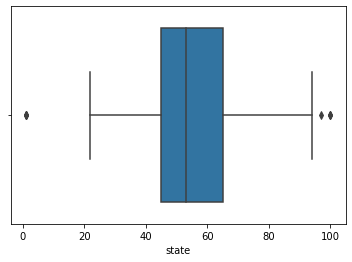

Durations:


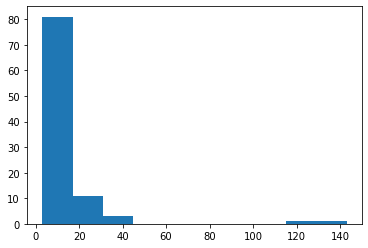

median duration: 9.0
mean duration: 13.577319587628866
-------------------------------------------------------------


TASK   AIClosing-1-6: Hattest du Spaß?
Von Sehr wenig bis Sehr viel
min: 1
max: 100
median: 75.0
mean: 74.09278350515464
std: 24.497457252533945


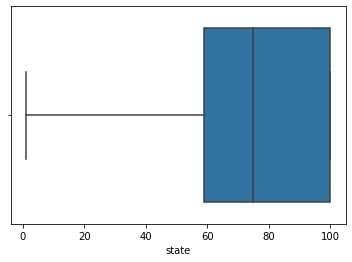

Durations:


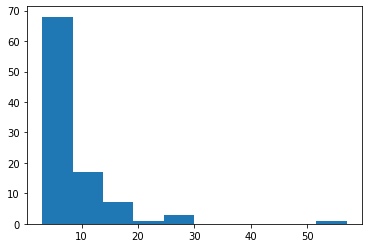

median duration: 7.0
mean duration: 8.577319587628866
-------------------------------------------------------------


TASK   AIClosing-1-7: Hast du etwas gelernt?
Von Sehr wenig bis Sehr viel
min: 1
max: 100
median: 76.0
mean: 74.88659793814433
std: 24.254610057564967


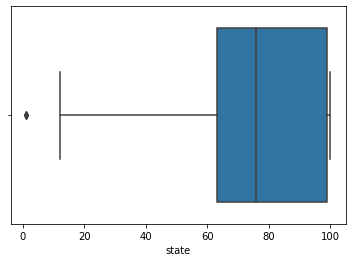

Durations:


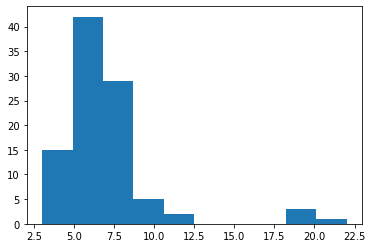

median duration: 6.0
mean duration: 6.701030927835052
-------------------------------------------------------------




In [7]:
outlier_tresh = 2

for i in surveysliders["taskId"].unique():
    slider_i = surveysliders[surveysliders["taskId"] == i]
    state_array = [int(entry) for entry in slider_i["state"]]
    duration_array = [int(entry) for entry in slider_i["duration"]]
    print("TASK   " + surveysliders[surveysliders["taskId"] == i]["taskId"].unique()[0] + ": " + surveysliders[surveysliders["taskId"] == i]["question"].unique()[0])
    print("Von " + str(surveysliders[surveysliders["taskId"] == i]["minLabel"].unique()[0]) + " bis " + str(surveysliders[surveysliders["taskId"] == i]["maxLabel"].unique()[0]))
    print("min: " + str(np.min(state_array)))
    print("max: " + str(np.max(state_array)))
    print("median: " + str(np.median(state_array)))
    print("mean: " + str(np.mean(state_array)))
    print("std: " + str(np.std(state_array)))
    ax = sns.boxplot(x=surveysliders[surveysliders["taskId"] == i]["state"])
    plt.show()
    #ax1 = sns.violinplot(x=state_array)
    #plt.show()
    #print("Ausreißer:")
    #print(surveysliders[(surveysliders["taskId"]==i) & ((surveysliders["state"]<=np.mean(state_array)-outlier_tresh*np.std(state_array)) | (surveysliders["state"]>=np.mean(state_array)+outlier_tresh*np.std(state_array)))][["pupilId", "state"]])
    #print("")
    print("Durations:")
    plt.hist(duration_array)
    plt.show()
    print("median duration: " + str(np.median(duration_array)))
    print("mean duration: " + str(np.mean(duration_array)))
    print("-------------------------------------------------------------")
    print("")
    print("")


## Freitext

### Länge der Abgaben

median length of freetext antwort: 14.0
mean length of freetext antwort: 20.739776951672862
std of length of freetext antwort: 23.17456659256489
50% are between 6.0 and 28.0 words long
min number of words: 0.0
max number of words: 379.0
Das sind nur die Längen der akzeptierten Antworten


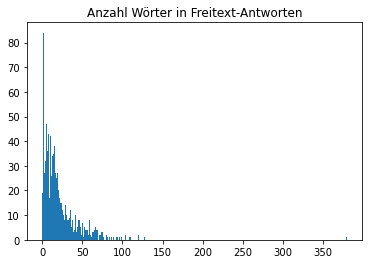

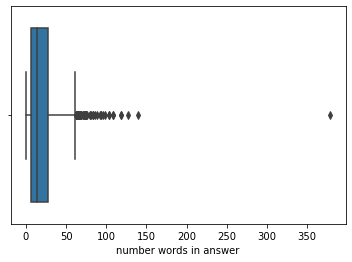

In [28]:
%%capture --no-stdout --no-display
print("median length of freetext antwort: " + str(np.median(freetext["number words in answer"])))
print("mean length of freetext antwort: " + str(np.mean(freetext["number words in answer"])))
print("std of length of freetext antwort: " + str(np.std(freetext["number words in answer"])))

q75, q25 = np.percentile(freetext["number words in answer"], [75 ,25])
print("50% are between " + str(q25) + " and " + str(q75) + " words long")

print("min number of words: " + str(np.min(freetext["number words in answer"])))
print("max number of words: " + str(np.max(freetext["number words in answer"])))
print("Das sind nur die Längen der akzeptierten Antworten")

#plt.hist(x=freetext["number words in answer"], bins=int(np.max(list(freetext["number words in answer"]))))
plt.hist(data=freetext, x="number words in answer", bins=int(np.max(list(freetext["number words in answer"]))))
plt.title("Anzahl Wörter in Freitext-Antworten")
plt.show()

sns.boxplot(freetext["number words in answer"])
plt.show()

### Kurze Antworten, die noch akzeptiert wurden

In [26]:
#was sind die kurzen antworten, die akzeptiert wurden?
freetext[(freetext["number words in answer"]<5) & (freetext["taskId"] != "AIClosing-1-8") & (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")][["pupilId", "classId", "taskId", "state", "question"]]

,pupilId,classId,taskId,state,question
254,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Impact-2-1-1,das Gesicht ist unscharf,Was für Probleme könnten durch den Einsatz von...
1000,jEu6xtqA4gGjdgqgm,GkQSJvPTRWsLnpyR9,AI-4-v2-1-3,kl heißt künstliche intelligenz,Jetzt weißt du schon mehr über KI. Sag nochmal...
1003,jEu6xtqA4gGjdgqgm,GkQSJvPTRWsLnpyR9,ML-1-1-1,.,"Kannst du einen Algorithmus schreiben, der Hun..."
1034,jEu6xtqA4gGjdgqgm,GkQSJvPTRWsLnpyR9,AIClosing-1-5,.<br>,"Du siehst also, dass die Erwartungen der Mensc..."
1046,iHYe2TGnR9zgGZ6zh,GkQSJvPTRWsLnpyR9,AI-4-v2-1-3,ja<br>,Jetzt weißt du schon mehr über KI. Sag nochmal...
...,...,...,...,...,...
6144,8SdsXqZ4kXoh2mEts,brSDebuCak3FfQsg6,AIClosing-1-5,Keine Sorge,"Du siehst also, dass die Erwartungen der Mensc..."
6162,Wt2cDGMkbhtxYj8ot,brSDebuCak3FfQsg6,LimitsML-1-2,Ja,"Was würde passieren, wenn wir alle Bilder von ..."
6188,Wt2cDGMkbhtxYj8ot,brSDebuCak3FfQsg6,AIClosing-1-5,Du wirst sterben,"Du siehst also, dass die Erwartungen der Mensc..."
6332,hEJx5G9X7gSRJSL4y,brSDebuCak3FfQsg6,EvalML-1-7,KI,"Beschreib noch einmal in eigenen Worten, was m..."


Erst noch die Antworten auf Fragen rausnehmen, zu denen SuS noch nichts wissen müssen.
Scheinen wenige SuS zu sein, von denen die Antworten trotzdem akzeptiert wurden.

vllt musste ein account hochgespielt werden

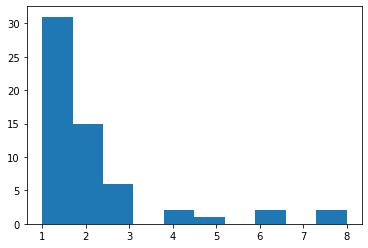

In [28]:
plt.hist(freetext[(freetext["number words in answer"]<5) & (freetext["taskId"] != "AIClosing-1-8")& (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")]["pupilId"].value_counts())
plt.show()

In [29]:
# kleiner als IQR25
freetext[(freetext["number words in answer"]<9) & (freetext["taskId"] != "AIClosing-1-8")& (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")][["pupilId", "classId", "taskId", "state", "question"]]

,pupilId,classId,taskId,state,question
188,jRT6yzZ2ip5ab5ZFM,qFEyvypMn4sAwLwtc,Impact-2-1-1,Man könnte damit verbrechen fälschen,Was für Probleme könnten durch den Einsatz von...
234,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Clustering-2-1-1,"<span style=""color: rgb(51, 51, 51);"">⠀</span>",Schau dir die Mittelpunkte der Cluster genau a...
244,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,LimitsML-1-2,"<span style=""color: rgb(51, 51, 51);"">⠀</span>","Was würde passieren, wenn wir alle Bilder von ..."
251,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,EvalML-1-7,"<span style=""color: rgb(51, 51, 51);"">⠀</span>...","Beschreib noch einmal in eigenen Worten, was m..."
254,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Impact-2-1-1,das Gesicht ist unscharf,Was für Probleme könnten durch den Einsatz von...
...,...,...,...,...,...
6332,hEJx5G9X7gSRJSL4y,brSDebuCak3FfQsg6,EvalML-1-7,KI,"Beschreib noch einmal in eigenen Worten, was m..."
6351,hEJx5G9X7gSRJSL4y,brSDebuCak3FfQsg6,AIClosing-1-5,schwierig<br>,"Du siehst also, dass die Erwartungen der Mensc..."
6375,SxzRMptJmyZPpiHxb,brSDebuCak3FfQsg6,LimitsML-1-2,Das Programm würde alle Seehunde als Hunde erk...,"Was würde passieren, wenn wir alle Bilder von ..."
6382,SxzRMptJmyZPpiHxb,brSDebuCak3FfQsg6,EvalML-1-7,"Maschinelles Lernen, ist lernen was Maschinenb...","Beschreib noch einmal in eigenen Worten, was m..."


<AxesSubplot:>

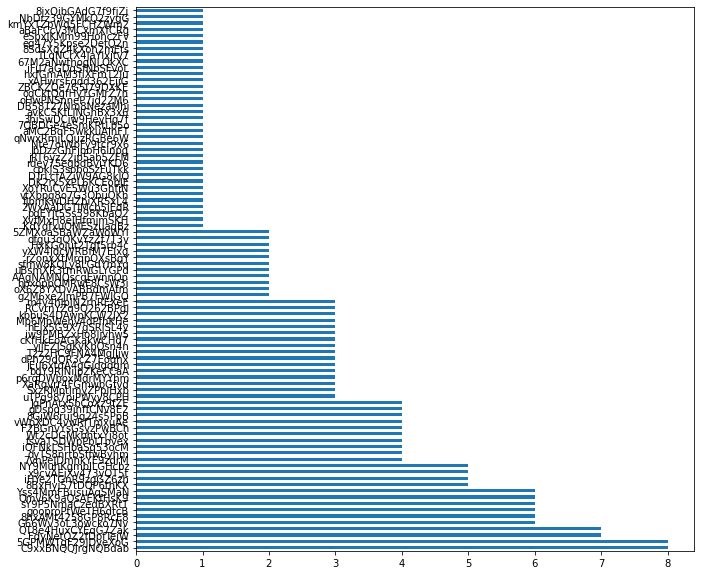

In [30]:
freetext[(freetext["number words in answer"]<9) & (freetext["taskId"] != "AIClosing-1-8")& (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")]["pupilId"].value_counts().plot(kind='barh', figsize=(10,10))

### Welche Antworten wurden nicht akzeptiert?

In [35]:
print(len(freetext[(freetext["evaluation"] == "false")]))
print(len(freetext[(freetext["evaluation"] == "correct")]))

64
712


Lehrkräfte geben kaum Aufgaben zurück

### Wurden Antworten mehrfach zurück gegeben?

(array([54.,  0.,  7.,  0.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

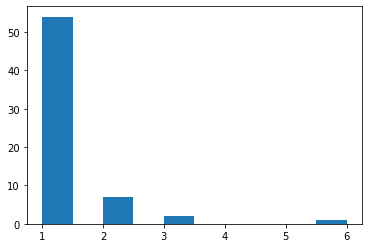

In [36]:
number_revisions = []

for i, task in freetext[freetext["evaluation"] == "false"].iterrows():
    number_revisions.append(len(task["falseAttempts"]))
    #print(len(task["falseAttempts"]))
    #if(len(task["falseAttempts"])>5):
    #    print(task["falseAttempts"])
    
plt.hist(number_revisions)

### Teacher Feedback

In [37]:
freetext["teacherFeedback"].value_counts()


                                                                                              719
Du brauchst die Antworten nicht neu abgeben, wenn du nichts änderst.                            5
0 Punkte                                                                                        3
Nein, es ist ewas anderes gemeint.                                                              1
Sehr allgemein formuliert :)                                                                    1
                                                                                             ... 
Du brauchst die Antworten nicht neu abgeben, nur wenn du etwas geändert hast                    1
ja oder den Seehund als Hund erkennen.                                                          1
Nicht nur für Menschen mit Behinderung. Gibt ja auch Alexa u.ä.\n                               1
Als Fernziel gut beschrieben, geht aber noch nicht auf das ein, was wir heute schon nutzen      1
der wedelnde Schwanz

### Ratings

content


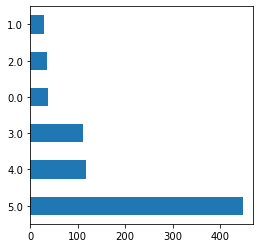

5.0    447
4.0    117
3.0    111
0.0     38
2.0     35
1.0     28
Name: rating_content, dtype: int64
format


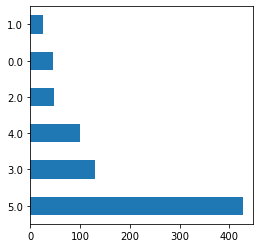

5.0    427
3.0    130
4.0    100
2.0     48
0.0     45
1.0     26
Name: rating_format, dtype: int64
creativity


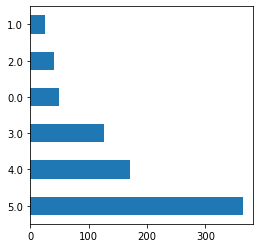

5.0    364
4.0    171
3.0    126
0.0     50
2.0     40
1.0     25
Name: rating_creativity, dtype: int64


In [51]:
#.plot(kind='barh', figsize=(10,10))

print("content")
freetext["rating_content"].value_counts().plot(kind='barh', figsize=(4,4))
plt.show()
print(freetext["rating_content"].value_counts())
print("format")
freetext["rating_format"].value_counts().plot(kind='barh', figsize=(4,4))
plt.show()
print(freetext["rating_format"].value_counts())
print("creativity")
freetext["rating_creativity"].value_counts().plot(kind='barh', figsize=(4,4))
plt.show()
print(freetext["rating_creativity"].value_counts())

IQR75 Content Rating: 5.0
Median Content Rating: 5.0
IQR25 Content Rating: 3.0
Mean Content Rating: 4.038659793814433
Std Content Rating: 1.4164170922101649

IQR75 format Rating: 5.0
Median format Rating: 5.0
IQR25 format Rating: 3.0
Mean format Rating: 3.926546391752577
Std format Rating: 1.4795919019450705

IQR75 creativity Rating: 5.0
Median creativity Rating: 4.0
IQR25 creativity Rating: 3.0
Mean creativity Rating: 3.8492268041237114
Std creativity Rating: 1.4614282733149804



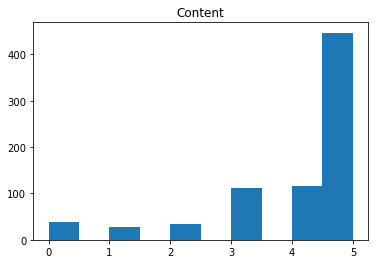

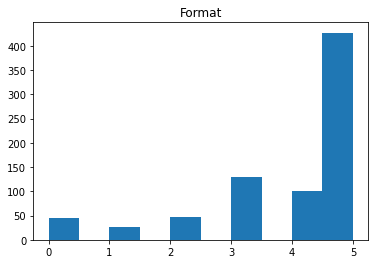

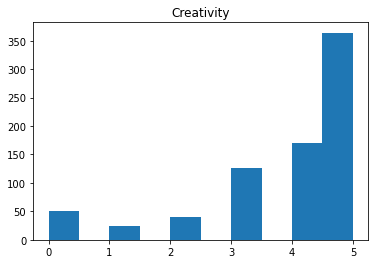

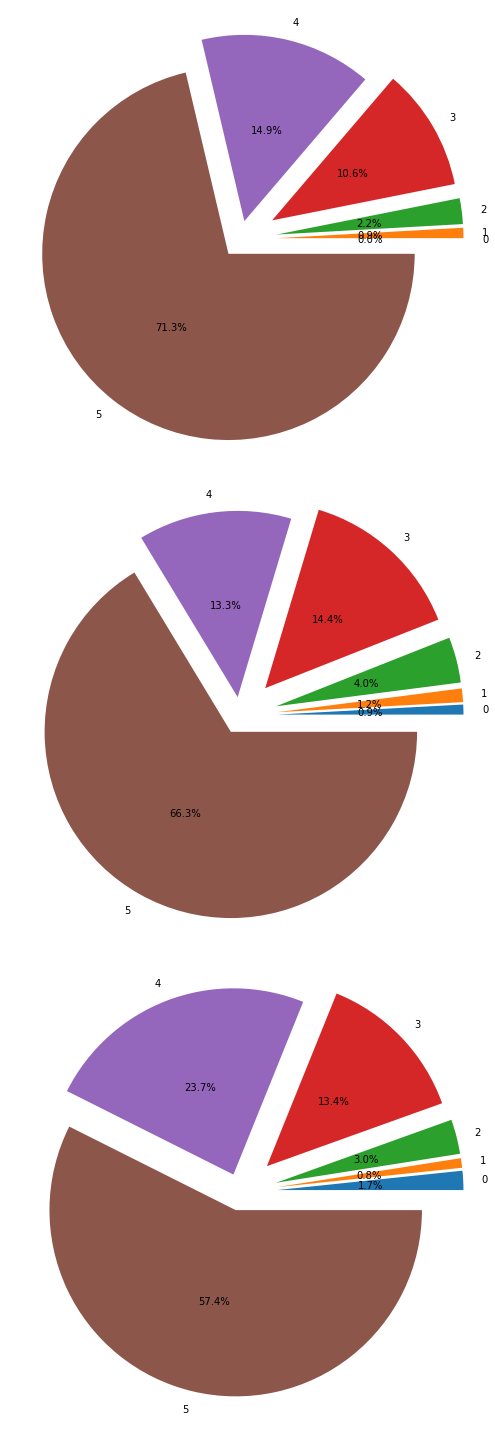

In [54]:
print("IQR75 Content Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_content"], 75)))
print("Median Content Rating: " + str(np.nanmedian(freetext["rating_content"])))
print("IQR25 Content Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_content"], 25)))
print("Mean Content Rating: " + str(np.mean(freetext["rating_content"])))
print("Std Content Rating: " + str(np.std(freetext["rating_content"])))
print("")

print("IQR75 format Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_format"], 75)))
print("Median format Rating: " + str(np.nanmedian(freetext["rating_format"])))
print("IQR25 format Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_format"], 25)))
print("Mean format Rating: " + str(np.mean(freetext["rating_format"])))
print("Std format Rating: " + str(np.std(freetext["rating_format"])))
print("")

print("IQR75 creativity Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_creativity"], 75)))
print("Median creativity Rating: " + str(np.nanmedian(freetext["rating_creativity"])))
print("IQR25 creativity Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_creativity"], 25)))
print("Mean creativity Rating: " + str(np.mean(freetext["rating_creativity"])))
print("Std creativity Rating: " + str(np.std(freetext["rating_creativity"])))
print("")
# TODO: der median muss hier noch falsch sein, der ist 4.0, obwohl es 5 sind


plt.hist(freetext["rating_content"])
plt.title("Content")
plt.show()
plt.hist(freetext["rating_format"])
plt.title("Format")
plt.show()
plt.hist(freetext["rating_creativity"])
plt.title("Creativity")
plt.show()


#boxplots bringen eig nichts!
#sns.boxplot(freetext[freetext["evaluation"] != "pending"]["rating_content"])
#plt.show()
#sns.boxplot(freetext[freetext["evaluation"] != "pending"]["rating_format"])
#plt.show()
#sns.boxplot(freetext[freetext["evaluation"] != "pending"]["rating_creativity"])
#plt.show()


# Pie charts
content_data = freetext[freetext["evaluation"] != "pending"].groupby("rating_content")["rating_content"].sum()
format_data = freetext[freetext["evaluation"] != "pending"].groupby("rating_format")["rating_content"].sum()
creativity_data = freetext[freetext["evaluation"] != "pending"].groupby("rating_creativity")["rating_content"].sum()
labels = ["0", "1", "2", "3", "4", "5"]
#content_labels = freetext[freetext["evaluation"] != "pending"]["rating_content"].unique()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[10,20])

ax1.pie(x=content_data, autopct="%.1f%%", explode = (0.2, 0.2, 0.2, 0.2, 0.1, 0.1), labels=labels, pctdistance=0.5)
ax2.pie(x=format_data, autopct="%.1f%%", explode = (0.2, 0.2, 0.2, 0.2, 0.1, 0.1), labels=labels, pctdistance=0.5)
ax3.pie(x=creativity_data, autopct="%.1f%%", explode = (0.2, 0.2, 0.2, 0.2, 0.1, 0.1), labels=labels, pctdistance=0.5)
plt.tight_layout()
plt.show()

## Durations

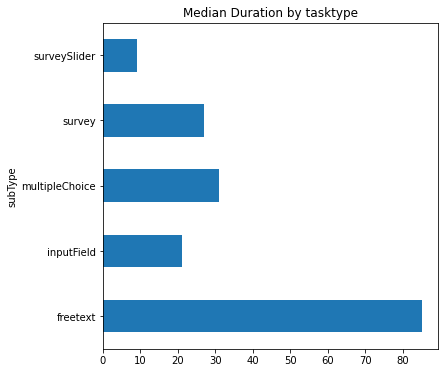

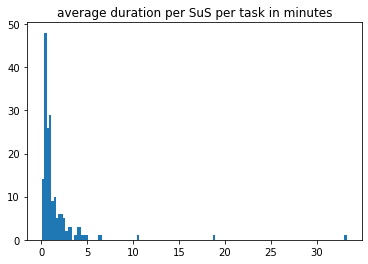

In [72]:
# All durations
#df.boxplot(column=['duration'])
#plt.title("all durations")
#plt.show()

# Per Subtype
#df.groupby("subType")["duration"].mean().plot(kind='barh', figsize=(6,6))
#plt.title("Mean Duration by tasktype")
#plt.show()

df.groupby("subType")["duration"].median().plot(kind='barh', figsize=(6,6))
plt.title("Median Duration by tasktype")
plt.show()

# Per Student
plt.hist(pupil_performance_df["average duration per task in minutes"], bins=int(np.max(pupil_performance_df["average duration per task in minutes"])/0.25))
plt.title("average duration per SuS per task in minutes")
plt.show()

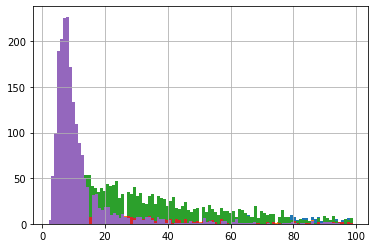

In [40]:
df.where(df["duration"]<100).groupby("subType")["duration"].hist(bins=100)
#ax.legend()
plt.show()
# TODO: vllt als 3d histogram? https://matplotlib.org/stable/gallery/mplot3d/hist3d.html

### Surveyslider - Durations

<AxesSubplot:>

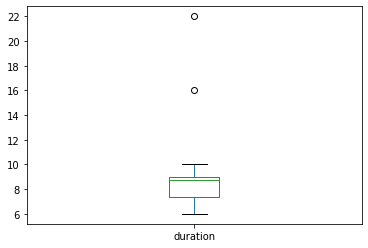

In [5]:
surveysliders.groupby("taskId").agg(np.median)[["duration"]].plot(kind="box")

<AxesSubplot:ylabel='taskId'>

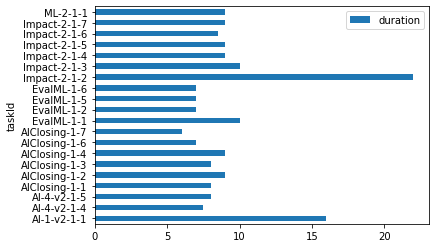

In [6]:
surveysliders.groupby("taskId").agg(np.median)[["duration"]].plot(kind="barh")

### Inputfield Durations
#### Gibt es Inputfields, bei denen die SuS besonders lange brauchen?

<AxesSubplot:>

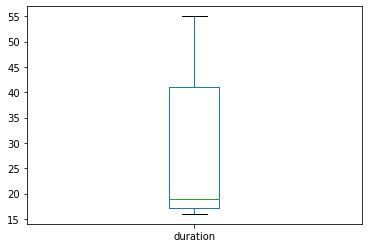

In [8]:
inputfields.groupby("taskId").agg(np.median)[["duration"]].plot(kind="box")

<AxesSubplot:ylabel='taskId'>

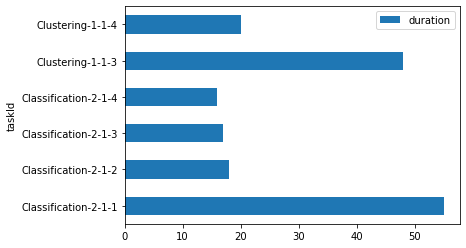

In [9]:
inputfields.groupby("taskId").agg(np.median)[["duration"]].plot(kind="barh")

#### Gibt es SoS, die bei besonders vielen Inputfields lange brauchen?

In [10]:
inputfields[inputfields["duration"] > np.percentile(inputfields["duration"], 95)][["pupilId"]].value_counts()

pupilId          
iw9PMBZxHo8Jjyhw5    3
zBgRiFyXPXhDqsqwb    2
FhFN5eiQduwiYKWEn    2
HxKGojut2Tgf5rb4c    2
dotjrftFetJme4iPH    2
eg47Y5Kpse2DetQ2n    2
Ay6mfswm3SFcQdNJg    2
j3AkifkKRR3t3NeoT    1
jRT6yzZ2ip5ab5ZFM    1
hpxopbQMRwF8CsW3i    1
rdey75egbdBviYKD6    1
hn2oJ5p2CwPfG44wx    1
hkj9srkmDxNs4oQPL    1
kNif57ypHXceM33Yk    1
kdqG4fXAK64zdrqN8    1
aiaYpPdYWJKb2hs7J    1
ZTvPk2i77LDC8pFmu    1
TLqNCrX4jaYixjtv7    1
oqCktQgfHyTGMrZ7n    1
qNwxRmjLQuzRGBe6W    1
hnSuDAuJxnggYbASM    1
dtype: int64

### MC Durations

##### Durchschnittsdauer der verschiedenen Multiple Chocie Aufgaben

<AxesSubplot:ylabel='taskId'>

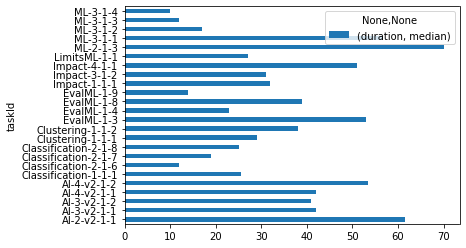

In [102]:
multipleChoice.groupby(["taskId"]).agg([np.median])[["duration"]].plot(kind="barh")

#### Sind manche der aufgaben nach median zeitliche ausreißer?

<AxesSubplot:>

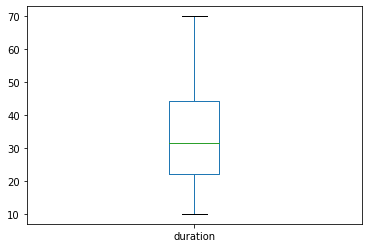

In [35]:
multipleChoice.groupby("taskId").agg(np.median)[["duration"]].plot(kind="box")

#### Bei welcher Aufgabe brauchen besonders viele SuS lange

In [13]:
multipleChoice[multipleChoice["duration"] > np.percentile(multipleChoice["duration"], 95)][["taskId"]].value_counts()

taskId              
ML-3-1-1                22
AI-4-v2-1-2             19
AI-2-v2-1-1             19
ML-2-1-3                12
Impact-1-1-1            10
AI-3-v2-1-1             10
Clustering-1-1-2         9
AI-4-v2-1-1              4
AI-3-v2-1-2              4
ML-3-1-3                 1
Impact-4-1-1             1
Impact-3-1-2             1
EvalML-1-3               1
Classification-2-1-7     1
dtype: int64

#### Benötigen immer die selben SuS besonders lange?

In [14]:
multipleChoice[multipleChoice["duration"] > np.percentile(multipleChoice["duration"], 95)][["pupilId"]].value_counts()

pupilId          
zBgRiFyXPXhDqsqwb    8
XKrLvRHLaM7yDisR6    6
6bBwnX2mwAp2NAwNR    5
FhFN5eiQduwiYKWEn    5
dotjrftFetJme4iPH    5
Ay6mfswm3SFcQdNJg    5
j3AkifkKRR3t3NeoT    4
TLqNCrX4jaYixjtv7    4
R8CkqGDeQXZmHxTuk    3
MRSj5LqwWj6WSoj4E    3
eg47Y5Kpse2DetQ2n    3
hnSuDAuJxnggYbASM    3
iFu7aGDqSfNbSFvoL    3
hn2oJ5p2CwPfG44wx    3
kdqG4fXAK64zdrqN8    3
n9zGaAFZH5uiAEoTH    3
BHDJ6HWSM5MZo6YSJ    2
x9cvAEjXv473yQT5t    2
7eqvpzMXwFGaYWHou    2
Kd6FuRsrq6QvPrkKp    2
X3JDYSzxpuDpoRjdJ    2
HxKGojut2Tgf5rb4c    2
ZTvPk2i77LDC8pFmu    2
Q9a6JY4zvQQ9qA2Ms    2
sfmw8KQLy8LGdYmYq    2
rsATbrReo6odn6oXD    2
C2BW6tdii778v4RfL    2
FefCz3MmxDeohgDKC    1
HicSWk5kkvcAz4H8w    1
Decqz7SuZcHMFsSAn    1
Absyuhryq96KZL2Cs    1
AezLL6wL4MCX2JYjB    1
8hxAMt4258GP8RcE8    1
NHPSudYwp9A4DT5t2    1
FtWfJrEwzd8oJCK7M    1
Z9DkQMmtiPiHtteME    1
T4iugPHxim5gX8M4i    1
jRT6yzZ2ip5ab5ZFM    1
vWpXDC4vwRfTmxuAe    1
vNMvj2EsvKXvqk3Qw    1
uo9M6NWSLj8opYpQq    1
sh2FJtxjHzAbFn9pb    1
rdey75egbdBviYKD

### Freitext Durations

<AxesSubplot:ylabel='taskId'>

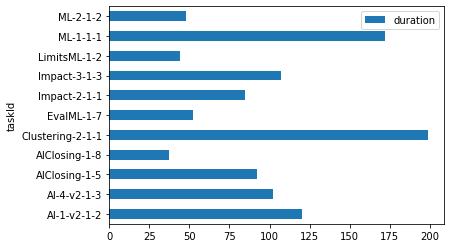

In [17]:
freetext.groupby("taskId").agg(np.median)[["duration"]].plot(kind="barh")

<AxesSubplot:>

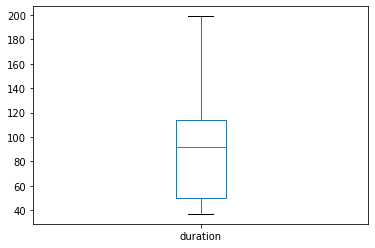

In [18]:
freetext.groupby("taskId").agg(np.median)[["duration"]].plot(kind="box")

keine Aufgabe ist formal gesehen ein ausreißer bei der Länge

Gibt es Ballungen bei Aufgaben oder SuS?

In [5]:
# bei welchen aufgaben brauchen besonders viele SuS sehr lange (sind über dem 95. duration perzentil) 
freetext[freetext["duration"] > np.percentile(freetext["duration"], 95)][["taskId"]].value_counts()

taskId          
AI-1-v2-1-2         15
ML-1-1-1            13
Clustering-2-1-1    11
AI-4-v2-1-3          9
Impact-3-1-3         3
ML-2-1-2             2
AIClosing-1-5        1
dtype: int64

In [6]:
# welche SuS brauchen besonders oft sehr lange (sind öfters über dem 95. duration perzentil) 
freetext[freetext["duration"] > np.percentile(freetext["duration"], 95)][["pupilId"]].value_counts()

pupilId          
6bBwnX2mwAp2NAwNR    4
dotjrftFetJme4iPH    4
TLqNCrX4jaYixjtv7    3
hn2oJ5p2CwPfG44wx    3
iFu7aGDqSfNbSFvoL    2
Absyuhryq96KZL2Cs    2
C2BW6tdii778v4RfL    2
Decqz7SuZcHMFsSAn    2
XKrLvRHLaM7yDisR6    2
hnSuDAuJxnggYbASM    2
zBgRiFyXPXhDqsqwb    2
j3AkifkKRR3t3NeoT    2
kdqG4fXAK64zdrqN8    2
29Lq4fguqCLhap77S    2
dfgu3qQKvYzZf7T3v    1
Z9DkQMmtiPiHtteME    1
3GGQqRsPRZK2LXnnC    1
3hiSwDCiw9HeyHg7f    1
sfmw8KQLy8LGdYmYq    1
7eqvpzMXwFGaYWHou    1
8jxQibGAdG7f9fjZj    1
rsATbrReo6odn6oXD    1
Ay6mfswm3SFcQdNJg    1
BHDJ6HWSM5MZo6YSJ    1
rdey75egbdBviYKD6    1
oX6Z8YXDvABBdmAfm    1
kNif57ypHXceM33Yk    1
MRSj5LqwWj6WSoj4E    1
PWuKnsCopAGh2sBNd    1
Pg7BFWmCtMbhidD3w    1
R8CkqGDeQXZmHxTuk    1
tFtNEGEvAWMPxNKri    1
n9zGaAFZH5uiAEoTH    1
Kd6FuRsrq6QvPrkKp    1
dtype: int64

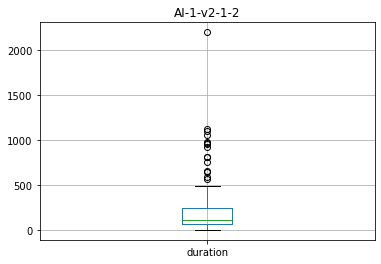

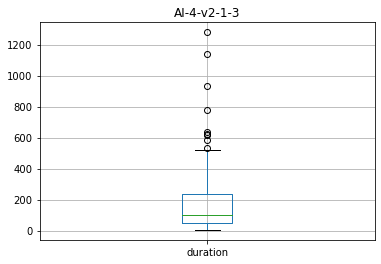

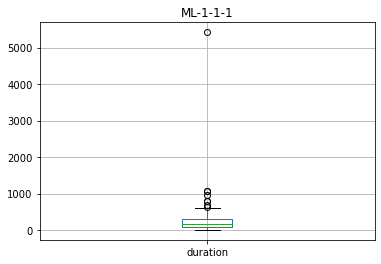

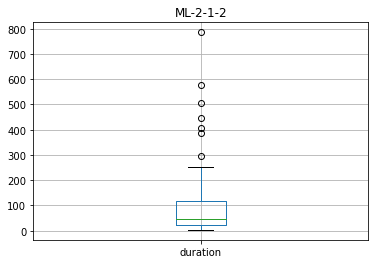

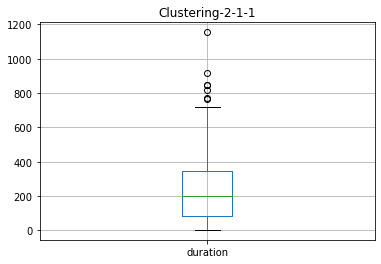

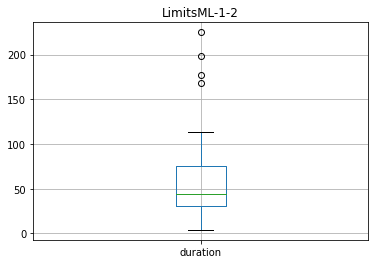

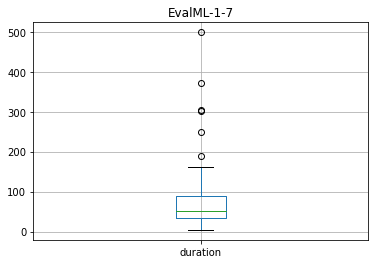

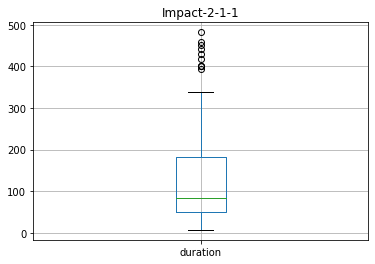

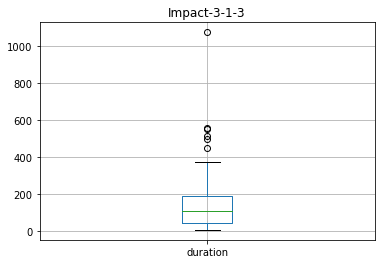

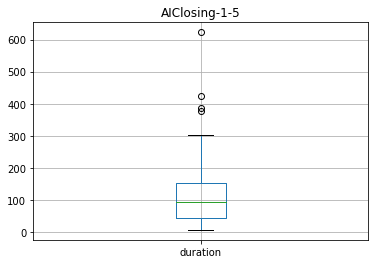

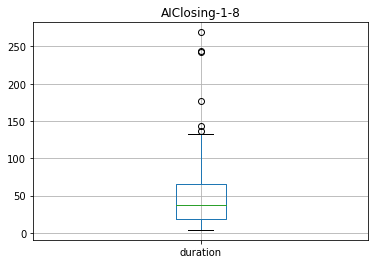

In [23]:
for taskid in freetext["taskId"].unique():
    task_i = freetext[freetext["taskId"] == taskid]
    task_i.boxplot(column=['duration'])
    plt.title(str(taskid))
    plt.show()

#### Welche Antworten haben besonders lange gebraucht?

In [38]:
# Welche Antworten haben besonders lange gebraucht?
freetext[freetext["duration"] > 700][["pupilId", "classId", "taskId", "duration", "state", "number words in answer"]]

,pupilId,classId,taskId,duration,state,number words in answer
67,Z9DkQMmtiPiHtteME,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,920,"<span style=""background-color: rgb(248, 246, 2...",50.0
137,Kd6FuRsrq6QvPrkKp,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,979,"Künstliche Intelligenz heißt, dass ein Roboter...",55.0
511,7eqvpzMXwFGaYWHou,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,958,"<span style=""background-color: rgb(232, 234, 2...",67.0
522,dotjrftFetJme4iPH,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,1063,"Meiner Meinung nach, künstliche Intelligenz is...",34.0
547,dotjrftFetJme4iPH,qFEyvypMn4sAwLwtc,Clustering-2-1-1,1154,Die Clusternummer 1 wäre für die Make-Up-Marke...,76.0
557,TLqNCrX4jaYixjtv7,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,1125,Künstliche Intelligenz ist wenn Programme durc...,66.0
564,TLqNCrX4jaYixjtv7,qFEyvypMn4sAwLwtc,AI-4-v2-1-3,778,Es gibt spezifische KI und die Vorstellung von...,41.0
603,hn2oJ5p2CwPfG44wx,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,818,Bei Künstlichen Intelligenzen wird durch das D...,34.0
618,hn2oJ5p2CwPfG44wx,qFEyvypMn4sAwLwtc,ML-2-1-2,786,"Maschinelles Lernen wird auch ""deep learning"" ...",60.0
628,hn2oJ5p2CwPfG44wx,qFEyvypMn4sAwLwtc,Clustering-2-1-1,770,"Das Beauty, Vlogs repräsentiert am ehesten ein...",75.0


In [59]:
# sind die langsamen schüler auch die, die nicht weit gekommen sind?
slow_freetext_pupils = freetext[freetext["duration"] > 700]["pupilId"].unique()

pupil_performance_df[pupil_performance_df.index.isin(slow_freetext_pupils)]

,nr_tasks_per_pupil,total_duration in minutes,average duration per task in minutes,AI-1-v2-1-1,AI-4-v2-1-4,EvalML-1-1,ML-2-1-1,EvalML-1-5,AI-4-v2-1-5,EvalML-1-2,...,AIClosing-1-7,AIClosing-1-8,AIClosing-1-8_null_answer,AIClosing-1-8_correct_points,AIClosing-1-8_incorrect_points,AIClosing-1-8_irrelevant_points,AIClosing-1-8_rating_content,AIClosing-1-8_rating_format,AIClosing-1-8_rating_creativity,classId
pupilId,,,,,,,,,,,,,,,,,,,,,
Z9DkQMmtiPiHtteME,4,25.950000,6.487500,43.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
Kd6FuRsrq6QvPrkKp,6,37.383333,6.230556,78.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
7eqvpzMXwFGaYWHou,11,43.800000,3.981818,69.0,53.0,NaN,NaN,NaN,43.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
dotjrftFetJme4iPH,35,117.250000,3.350000,76.0,49.0,NaN,54.0,NaN,88.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
TLqNCrX4jaYixjtv7,46,124.000000,2.695652,51.0,61.0,66.0,53.0,75.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
hn2oJ5p2CwPfG44wx,54,123.000000,2.277778,71.0,99.0,79.0,77.0,100.0,100.0,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
kdqG4fXAK64zdrqN8,54,122.783333,2.273765,51.0,60.0,69.0,62.0,69.0,58.0,62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
Absyuhryq96KZL2Cs,15,63.150000,4.210000,89.0,96.0,NaN,NaN,NaN,33.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
XKrLvRHLaM7yDisR6,23,91.550000,3.980435,100.0,59.0,NaN,53.0,NaN,52.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
